# Compare Auxtel Fitted Spectra and comparison with Merra2

- Author : Sylvie Dagoret-Campagne
- creation date : 2024-01-30
- last update : 2024-02-06
- last update : 2024-03-12 : retrieve atmospheric parameters to save in a file (compare with LightCurves
- affiliation : IJCLab/IN2P3/CNRS

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from spectractor.tools import from_lambda_to_colormap, wavelength_to_rgb
#%matplotlib widget 
import h5py
from scipy import interpolate
from astropy.time import Time
import re
import seaborn as sns
import os

In [54]:
from collections import OrderedDict
import pickle

In [2]:
import matplotlib.ticker
%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = (18,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  12
plt.rcParams['font.size'] = 12

In [4]:
# SMOOTHING

def smooth_data_convolve_my_average(arr, span):
    re = np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

    # The "my_average" part: shrinks the averaging window on the side that 
    # reaches beyond the data, keeps the other side the same size as given 
    # by "span"
    re[0] = np.average(arr[:span])
    for i in range(1, span + 1):
        re[i] = np.average(arr[:i + span])
        re[-i] = np.average(arr[-i - span:])
    return re

def smooth_data_np_average(arr, span):  # my original, naive approach
    return [np.average(arr[val - span:val + span + 1]) for val in range(len(arr))]

def smooth_data_np_convolve(arr, span):
    return np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

def smooth_data_np_cumsum_my_average(arr, span):
    cumsum_vec = np.cumsum(arr)
    moving_average = (cumsum_vec[2 * span:] - cumsum_vec[:-2 * span]) / (2 * span)

    # The "my_average" part again. Slightly different to before, because the
    # moving average from cumsum is shorter than the input and needs to be padded
    front, back = [np.average(arr[:span])], []
    for i in range(1, span):
        front.append(np.average(arr[:i + span]))
        back.insert(0, np.average(arr[-i - span:]))
    back.insert(0, np.average(arr[-2 * span:]))
    return np.concatenate((front, moving_average, back))

def smooth_data_lowess(arr, span):
    x = np.linspace(0, 1, len(arr))
    return sm.nonparametric.lowess(arr, x, frac=(5*span / len(arr)), return_sorted=False)

def smooth_data_kernel_regression(arr, span):
    # "span" smoothing parameter is ignored. If you know how to 
    # incorporate that with kernel regression, please comment below.
    kr = KernelReg(arr, np.linspace(0, 1, len(arr)), 'c')
    return kr.fit()[0]

def smooth_data_savgol_0(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 0)

def smooth_data_savgol_1(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 1)

def smooth_data_savgol_2(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 2)

def smooth_data_fft(arr, span):  # the scaling of "span" is open to suggestions
    w = fftpack.rfft(arr)
    spectrum = w ** 2
    cutoff_idx = spectrum < (spectrum.max() * (1 - np.exp(-span / 2000)))
    w[cutoff_idx] = 0
    return fftpack.irfft(w)


# Read pandas Series

In [5]:
files_spectra_dir = [ "Data_Auxtel_Spectro/selected_1jan-28feb2023/spectra_transmission_ratio", 
          "Data_Auxtel_Spectro/selected_1march-14sept2023/spectra_transmission_ratio",
          "Data_Auxtel_Spectro/selected_27sept-07dec2023/spectra_transmission_ratio"
        ]
def get_spectra_path(nightobs):
    if nightobs <= 20230228:
        return files_spectra_dir[0]
    elif nightobs <= 20230914:
         return files_spectra_dir[1]
    else:
         return files_spectra_dir[2]

In [6]:

files = [ "Data_Auxtel_Spectro/selected_1jan-28feb2023/out_allfittedparams_selected_1jan-28feb2023.csv", 
          "Data_Auxtel_Spectro/selected_1march-14sept2023/out_allfittedparams_selected_1march-14sept2023.csv",
          "Data_Auxtel_Spectro/selected_27sept-07dec2023/out_allfittedparams_selected_27sept-07dec2023.csv"
        ]
N = len(files)

In [7]:
all_df = [pd.read_csv(files[idx], index_col=0, header=0) for idx in range(N)]

In [8]:
df = pd.concat(all_df)

In [9]:
df.head()

id  BITPIX  NAXIS  NAXIS1  \
DATE-OBS                                                                    
2023-01-18 02:33:44.320492641+00:00  2023011700238     -64      2    1066   
2023-01-18 02:34:27.138506292+00:00  2023011700239     -64      2    1066   
2023-01-18 02:43:58.366995924+00:00  2023011700243     -64      2    1067   
2023-01-18 02:44:41.368008749+00:00  2023011700244     -64      2    1066   
2023-01-18 03:05:56.221990758+00:00  2023011700249     -64      2    1066   

                                     NAXIS2  EXTEND    TARGET  REDSHIFT  \
DATE-OBS                                                                  
2023-01-18 02:33:44.320492641+00:00       3    True  HD185975 -0.000065   
2023-01-18 02:34:27.138506292+00:00       3    True  HD185975 -0.000065   
2023-01-18 02:43:58.366995924+00:00       3    True  HD074000  0.000687   
2023-01-18 02:44:41.368008749+00:00       3    True  HD074000  0.000687   
2023-01-18 03:05:56.221990758+00:00       3    True  HD185975 -0.000065   

                                       GRATING  ROTANGLE  ...  PWV [mm]_err_y  \
DATE-OBS                                                  ...                   
2023-01-18 02:33:44.320492641+00:00  holo4_003  0.142843  ...        0.031225   
2023-01-18 02:34:27.138506292+00:00  holo4_003  0.137532  ...        0.030546   
2023-01-18 02:43:58.366995924+00:00  holo4_003  0.165397  ...        0.049876   
2023-01-18 02:44:41.368008749+00:00  holo4_003  0.169342  ...        0.054533   
2023-01-18 03:05:56.221990758+00:00  holo4_003  0.141368  ...        0.028708   

                                     reso [pix]  reso [pix]_err  D_CCD [mm]_y  \
DATE-OBS                                                                        
2023-01-18 02:33:44.320492641+00:00    1.209370        0.028397    186.800590   
2023-01-18 02:34:27.138506292+00:00    1.211153        0.035841    186.824461   
2023-01-18 02:43:58.366995924+00:00    1.735232        0.044659    186.943501   
2023-01-18 02:44:41.368008749+00:00    1.577680        0.047941    186.878151   
2023-01-18 03:05:56.221990758+00:00    1.293266        0.032606    186.769243   

                                     D_CCD [mm]_err_y  alpha_pix [pix]  \
DATE-OBS                                                                 
2023-01-18 02:33:44.320492641+00:00          0.004384         1.005575   
2023-01-18 02:34:27.138506292+00:00          0.005769         0.950434   
2023-01-18 02:43:58.366995924+00:00          0.007737         1.012003   
2023-01-18 02:44:41.368008749+00:00          0.008278         1.035143   
2023-01-18 03:05:56.221990758+00:00          0.005339         1.029986   

                                     alpha_pix [pix]_err  B_y  B_err_y  \
DATE-OBS                                                                 
2023-01-18 02:33:44.320492641+00:00                  0.0  0.0      0.0   
2023-01-18 02:34:27.138506292+00:00                  0.0  0.0      0.0   
2023-01-18 02:43:58.366995924+00:00                  0.0  0.0      0.0   
2023-01-18 02:44:41.368008749+00:00                  0.0  0.0      0.0   
2023-01-18 03:05:56.221990758+00:00                  0.0  0.0      0.0   

                                     filtered  
DATE-OBS                                       
2023-01-18 02:33:44.320492641+00:00      True  
2023-01-18 02:34:27.138506292+00:00      True  
2023-01-18 02:43:58.366995924+00:00      True  
2023-01-18 02:44:41.368008749+00:00      True  
2023-01-18 03:05:56.221990758+00:00     False  

[5 rows x 169 columns]

In [10]:
def convertNumToDatestr(num):
    year = num//1000_000_000
    month= (num-year*1000_000_000)//10_000_000
    day = (num-year*1000_000_000-month*10_000_000)//100_000

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return pd.to_datetime(datestr)
    #return datestr

In [11]:
print(df.id.values)

[2023011700238 2023011700239 2023011700243 ... 2023120700435 2023120700452
 2023120700453]


In [12]:
df['nightobs'] = df.id.values//100_000

In [13]:
df['dateobs']=[convertNumToDatestr(num) for num in df.id.values ]

## Remove non Photometric Nights

In [14]:
NonPhotometricNights = [20230201,20230202,20230315,20230316,20230510,20230520,20230523,20230524,20230525,20230718,20230720,20230815,20230817,20230912]

In [15]:
PhotometricNightSelector  = lambda x : True if x not in NonPhotometricNights else False

In [16]:
df['PhotometricNight_Flag'] = df['nightobs'].apply(PhotometricNightSelector)

In [17]:
df = df[df['PhotometricNight_Flag']].drop(['PhotometricNight_Flag'],axis=1)

## Check Spectra quality

In [18]:
df1 = df[(df['nightobs']>=20230117) & (df['nightobs']<=20230228)]
df2 = df[(df['nightobs']>=20230301) & (df['nightobs']<=20230914)]
df3 = df[(df['nightobs']>=20230927) & (df['nightobs']<=20231207)]

In [19]:
print("df1 : ",df1.nightobs.unique())
print("df2 : ",df2.nightobs.unique())
print("df3 : ",df3.nightobs.unique())

df1 :  [20230117 20230118 20230119 20230131 20230214 20230215 20230216 20230228]
df2 :  [20230301 20230302 20230314 20230509 20230511 20230802 20230829 20230913
 20230914]
df3 :  [20230927 20230928 20231010 20231107 20231108 20231113 20231114 20231115
 20231116 20231120 20231127 20231128 20231129 20231130 20231204 20231205
 20231206 20231207]


In [20]:
def get_all_data_fromhf(hf):

    def get_attrs(name,obj):
        d = {}
        for key, val in obj.attrs.items():
            d[key] = val
        return d
    
    all_attributes = {}
    all_datasets = {}
    list_of_keys = list(hf.keys())

    # loop on each key of top level groups
    for key in list_of_keys: 
        group = hf.get(key)
    
        # retrieve all attributes for each group
        all_attributes[key] = get_attrs(key,group)

        datasets = {}
        for name, h5obj in group.items():
            if isinstance(h5obj,h5py.Group):
                pass
                # just check if there are subgroups that would need to be red recursively
                #print("\t >>> ",key,' / ',name,'is a Group')
         
            elif isinstance(h5obj,h5py.Dataset):
                #print("\t >>> ", key , name,'is a Dataset')
                arr = h5obj[:]
                #arr = hf[name][:] # same thing
                # add that dataset to the current group datasets
                datasets[name] = arr
    
        all_datasets[key] = datasets  
    return  list_of_keys, all_attributes ,all_datasets

In [21]:
def PlotTransmission(hf,nightobs):

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    def convertNumToDatestr2(num):
        year = num//10_000
        month= (num-year*10_000)//100
        day = (num-year*10_000-month*100)

        year_str = str(year).zfill(4)
        month_str = str(month).zfill(2)
        day_str = str(day).zfill(2)
    
        datestr = f"{year_str}-{month_str}-{day_str}"
        return datestr

    DATEOBS_STR = convertNumToDatestr2(nightobs)

    # retrieve all data from the hdf file
    list_of_keys, all_attributes ,all_datasets = get_all_data_fromhf(hf)

    # the data with their sequence number
    spec_nums_list = ["spec_" + re.findall("^spec_(.*)", keyname)[0] for keyname in list_of_keys if len(re.findall("^spec_(.*)", keyname)) > 0 ] 


    # targets
    all_targets = []
    textstr2 = ''

    for idx,spec_num in enumerate(spec_nums_list):
        the_attrs = all_attributes[spec_num]
        the_target = the_attrs['target']
        info = f"{nightobs} :: {spec_num} , tg = {the_target} "
        textstr2 = '\n'.join((textstr2,info))
        all_targets.append(the_target)
    
    targets_unique = np.unique(all_targets)
    Ntags = len(targets_unique )
    cmap = sns.color_palette("husl", Ntags)

    #text string
    atm = all_attributes['median_param_atm']
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    textstr = '\n'.join((
    r'$PWV=%.3f$ mm' % (atm["md_PWV"], ),
    r'$ozone=%.1f$ DU' % (atm["md_ozone"], ),
    r'$VAOD=%.3f$' % (atm['md_VAOD'], )))
    
    # plot
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,8),sharex=True)

    color_counts = np.zeros(Ntags)

    # loop on data
    for idx,spec_num in enumerate(spec_nums_list):
        the_dataset = all_datasets[spec_num]
        the_attrs = all_attributes[spec_num]
        the_target = the_attrs['target']

        the_label = the_target

        idxc = np.where(targets_unique== the_target )[0][0]
        the_col = cmap[idxc]
    
 
        all_targets.append(the_target)
        the_airmass = the_attrs['airmass']
        the_flag = the_attrs['flag_atmparam']
        the_title = f"{spec_num} , target = {the_target}"
    
   
        wls = the_dataset['wls']
        fls = the_dataset['fls']
        fls_err = the_dataset['fls_err']

        ratio_airmass1 = the_dataset['ratio_airmass1']
        wlr = the_dataset['wlr']

        span=3
        ratio_airmass2 = smooth_data_np_convolve(ratio_airmass1,span)
        
        if color_counts[idxc] == 0:
            ax1.plot(wls,fls,'-', color= the_col,label = the_label)
            ax2.plot(wlr,ratio_airmass2,'-', color= the_col,label=the_label)
            color_counts[idxc] = color_counts[idxc]+1
        else:
            ax1.plot(wls,fls,'-', color= the_col)
            ax2.plot(wlr,ratio_airmass2,'-', color= the_col)
            color_counts[idxc] = color_counts[idxc]+1

        
    # the simulation
    the_sim = all_datasets['sim_spec']
    transm = the_sim["transm"] 
    wls = the_sim["wls"] 
    ax2.plot(wls,transm,'k',label="simulation")
    ax2.text(0.75, 0.25, textstr, transform=ax2.transAxes, fontsize=14,verticalalignment='top', bbox=props)
   
    ax2.set_ylim(0.,1.2)  
    ax1.legend()  
    ax2.legend()
    ax1.set_title(f"{DATEOBS_STR}")
    ax1.set_xlim(370.,980.)
    ax2.set_xlabel("wavelength (nm)")
    ax1.set_ylabel("flux (ergs/cm$^2$/s/nm)")
    ax2.set_ylabel("atmospheric transmission")
    ax1.text(1.1, 1.0, textstr2, transform=ax1.transAxes, fontsize=10, verticalalignment='top', bbox=props)
        #plt.tight_layout()
    plt.subplots_adjust(wspace=None, hspace=0)
    plt.show()

In [50]:
def RetrieveAtmParameters(hf,nightobs):

    
    def convertNumToDatestr2(num):
        year = num//10_000
        month= (num-year*10_000)//100
        day = (num-year*10_000-month*100)

        year_str = str(year).zfill(4)
        month_str = str(month).zfill(2)
        day_str = str(day).zfill(2)
    
        datestr = f"{year_str}-{month_str}-{day_str}"
        return datestr

    DATEOBS_STR = convertNumToDatestr2(nightobs)

    # retrieve all data from the hdf file
    list_of_keys, all_attributes ,all_datasets = get_all_data_fromhf(hf)

    # the data with their sequence number
    spec_nums_list = ["spec_" + re.findall("^spec_(.*)", keyname)[0] for keyname in list_of_keys if len(re.findall("^spec_(.*)", keyname)) > 0 ] 


    # targets
    all_targets = []
    textstr2 = ''

    for idx,spec_num in enumerate(spec_nums_list):
        the_attrs = all_attributes[spec_num]
        the_target = the_attrs['target']
        info = f"{nightobs} :: {spec_num} , tg = {the_target} "
        textstr2 = '\n'.join((textstr2,info))
        all_targets.append(the_target)
    
    targets_unique = np.unique(all_targets)
    Ntags = len(targets_unique )
    cmap = sns.color_palette("husl", Ntags)

    #text string
    atm = all_attributes['median_param_atm']
    
    #textstr = '\n'.join((
    #r'$PWV=%.3f$ mm' % (atm["md_PWV"], ),
    #r'$ozone=%.1f$ DU' % (atm["md_ozone"], ),
    #r'$VAOD=%.3f$' % (atm['md_VAOD'], )))
        
  
    all_attrs = []
    # loop on data
    for idx,spec_num in enumerate(spec_nums_list):
        the_dataset = all_datasets[spec_num]
        the_attrs = all_attributes[spec_num]
     
        all_attrs.append(the_attrs)  

    
    return all_attributes,all_attrs


## To save selected night parameters in a Dict

In [56]:
AtmParamPerNightObsDict = OrderedDict()
file_atmparamselectednights =  'AtmParamPerNightObsDict.pkl'

### Check quality in nights in df1 

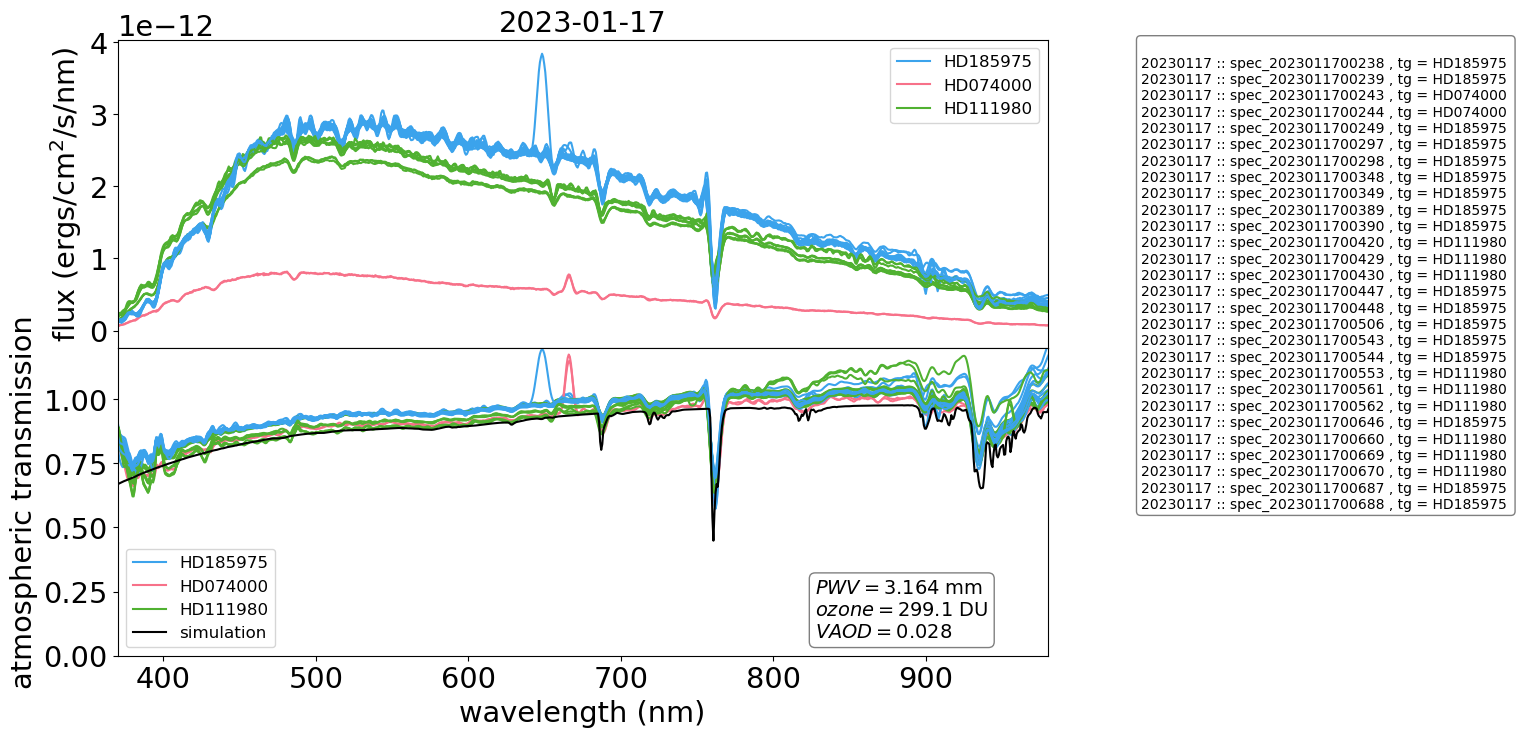

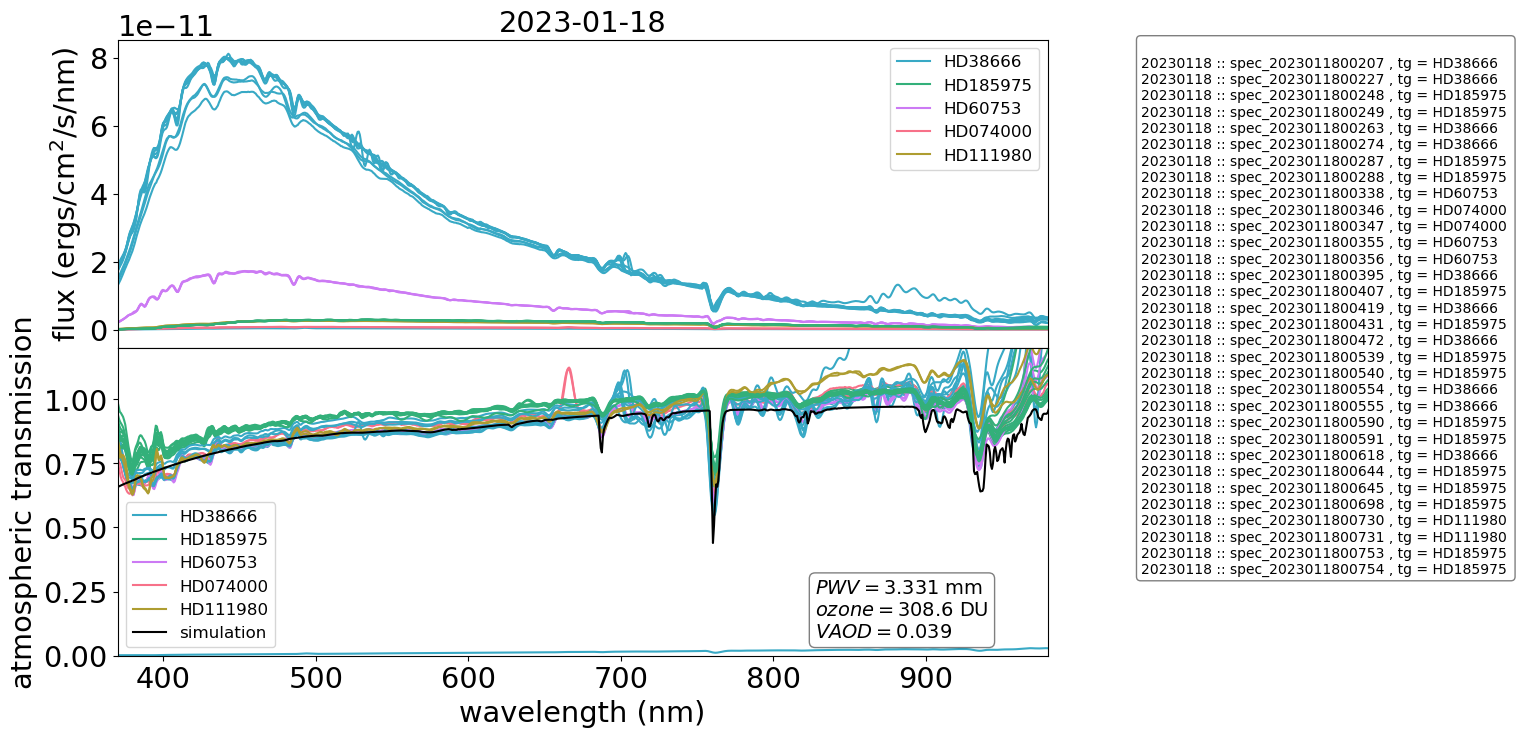

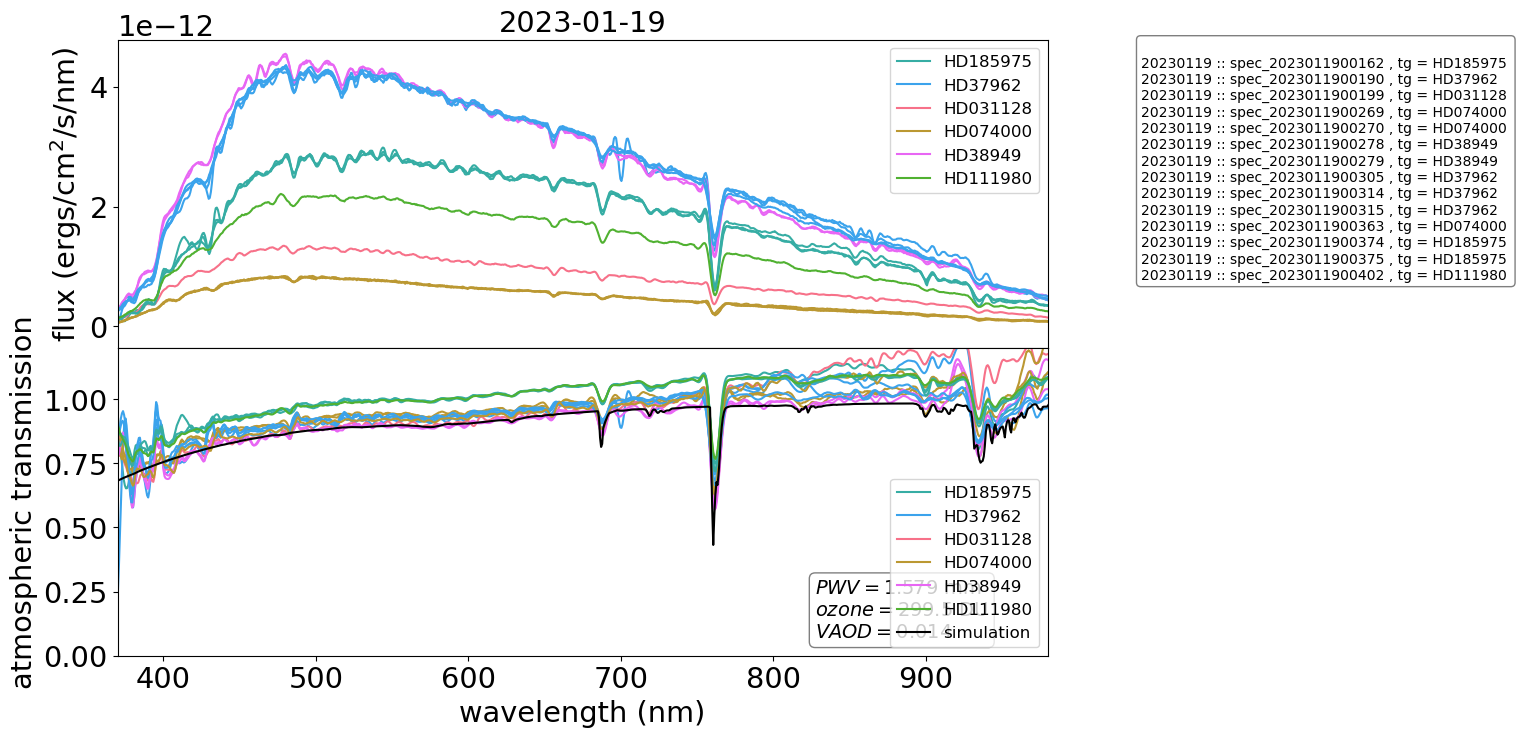

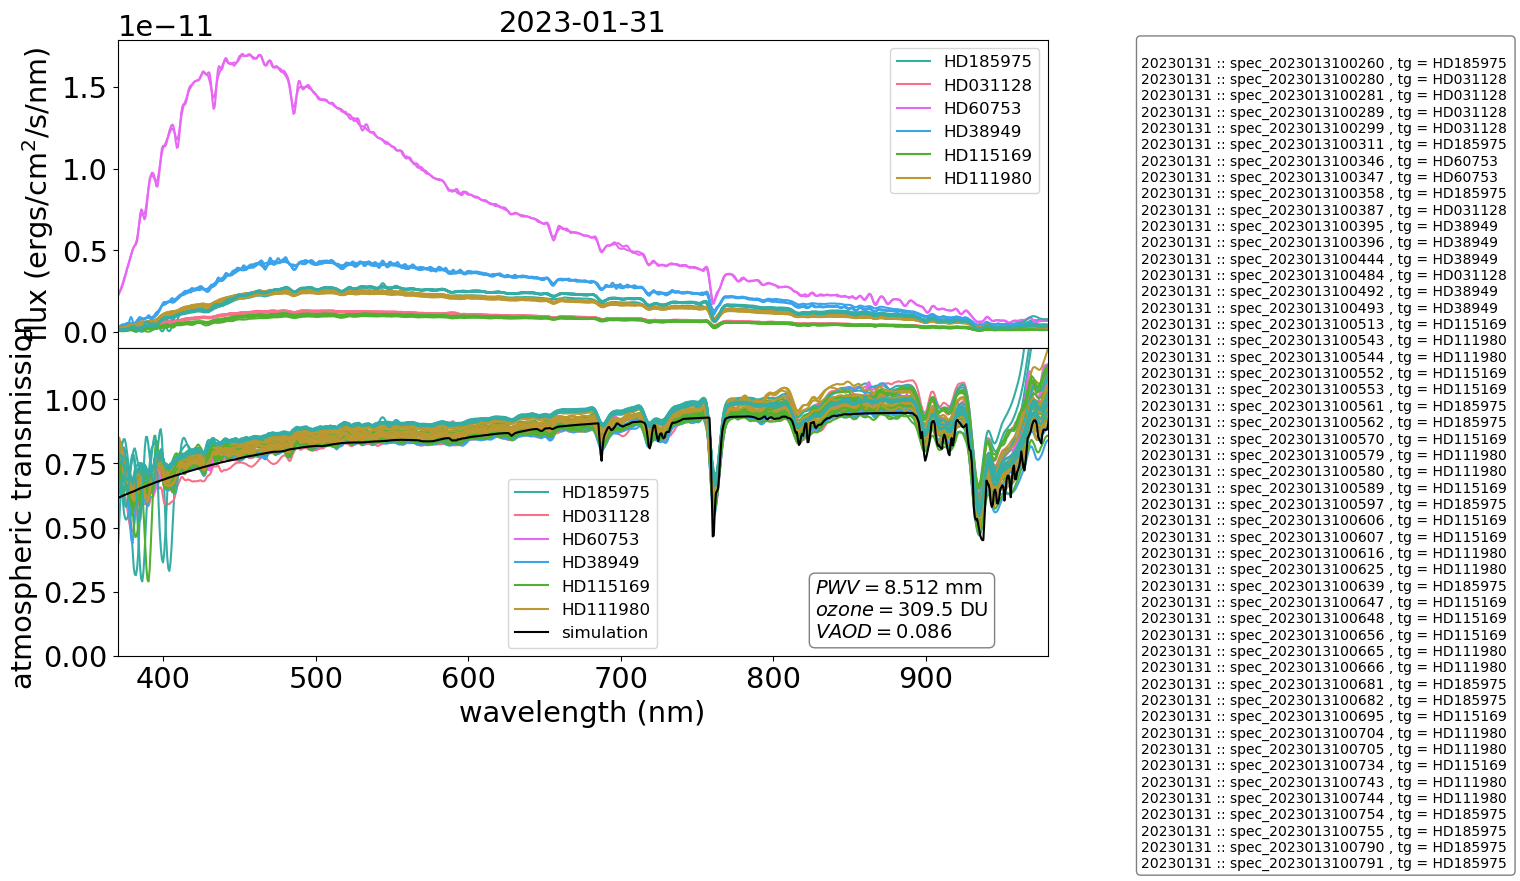

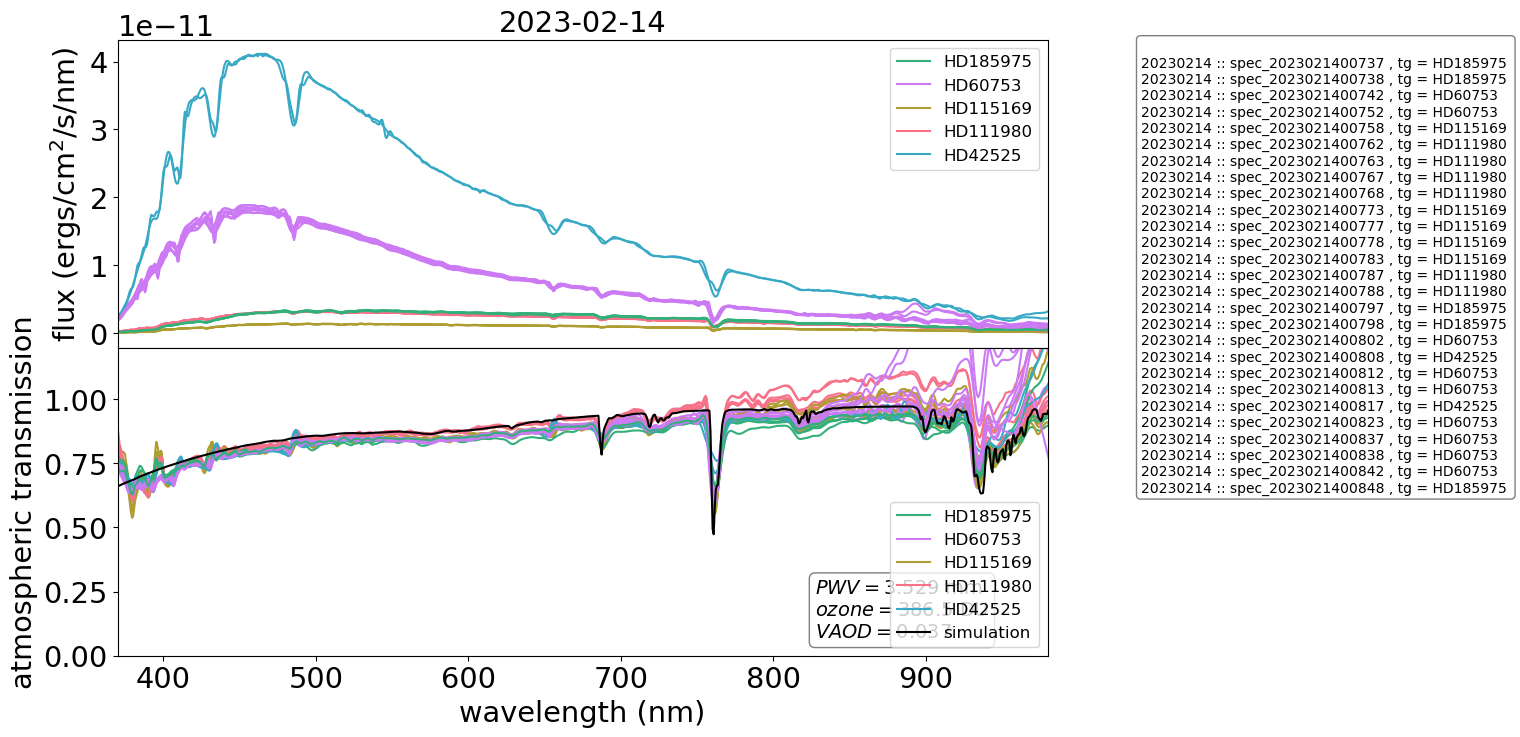

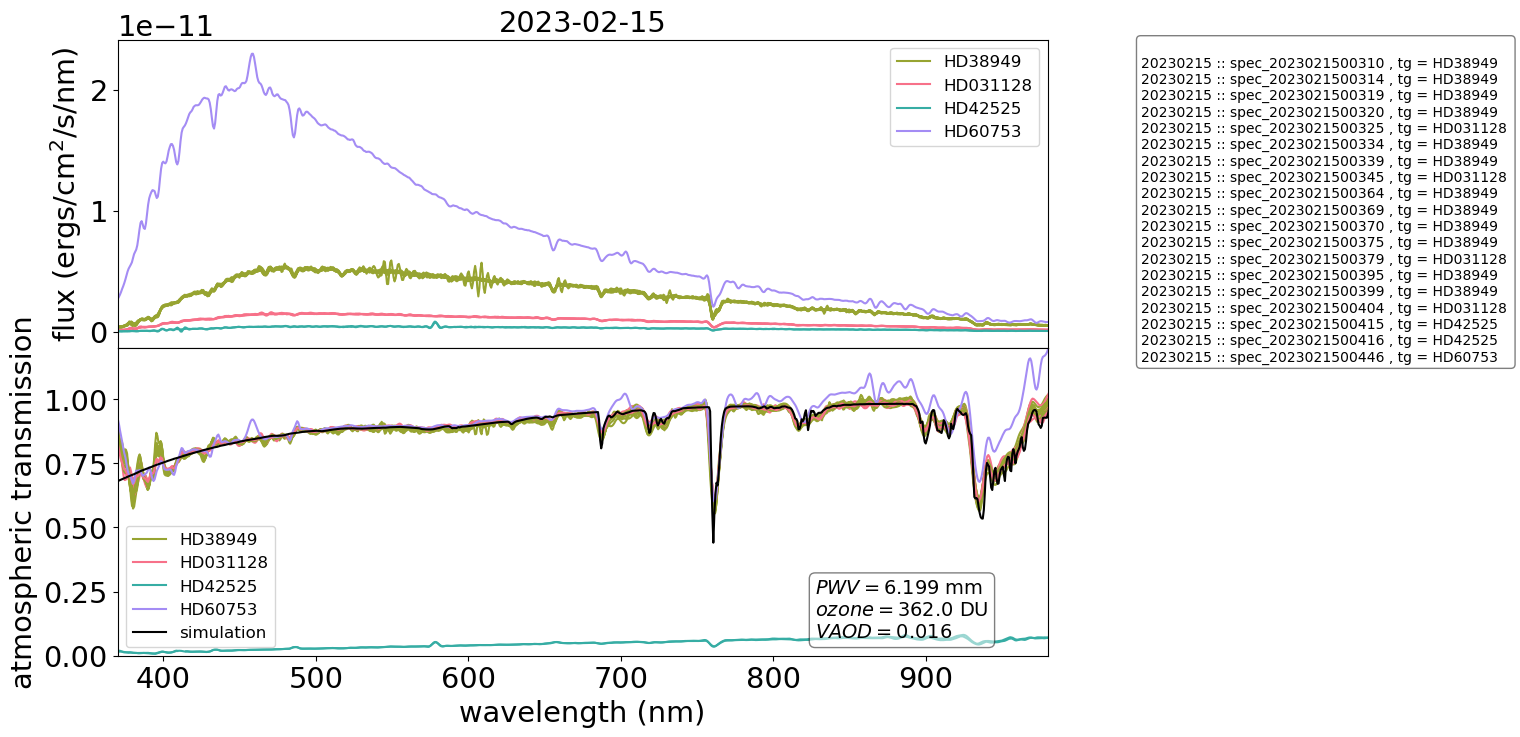

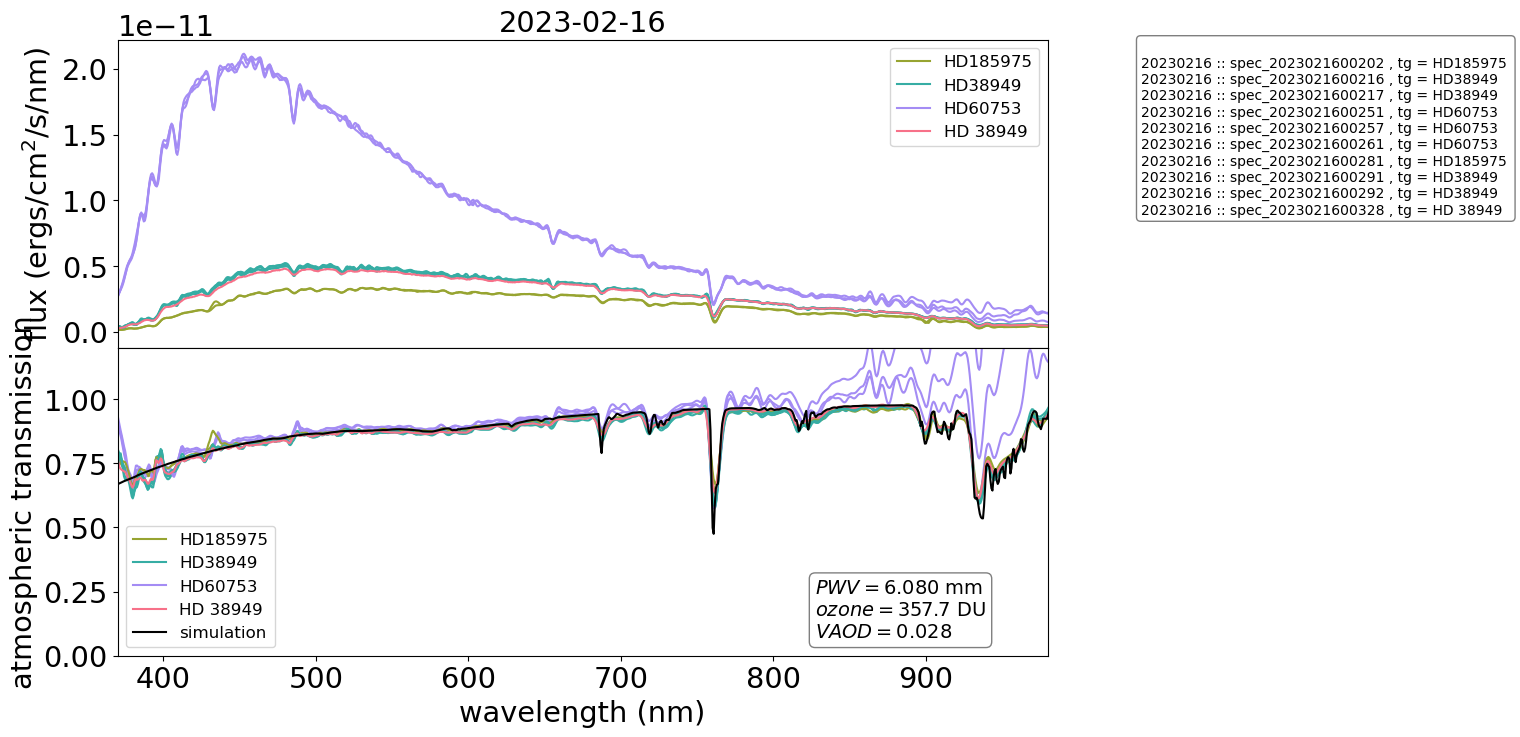

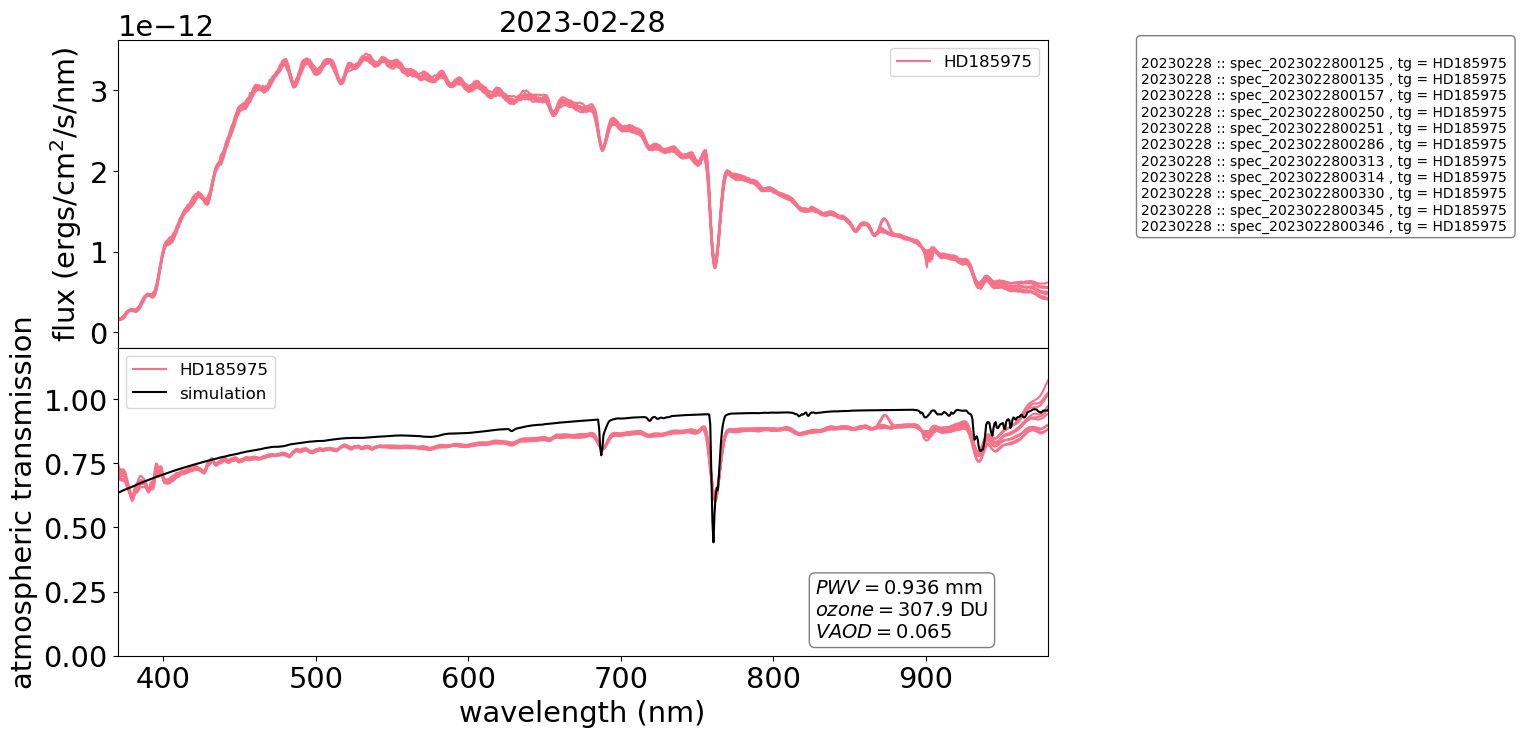

In [23]:
for nightobs in df1.nightobs.unique():
    path = get_spectra_path(nightobs)
    filename = f"spectra_transmission_ratio_{nightobs}.h5"
    fullfilename = os.path.join(path,filename)
    try:
        hf = h5py.File(fullfilename, 'r')
        PlotTransmission(hf,nightobs)
        tokeep = RetrieveAtmParameters(hf,nightobs)
        AtmParamPerNightObsDict[nightobs] = {"median":tokeep[0],"individual":tokeep[1]}
        hf.close()
    except Exception as inst:
        print(type(inst))    # the exception type
        print(inst.args)     # arguments stored in .args
        print(inst)          # __str__ allows args to be printed directly,

## Quality night in df2

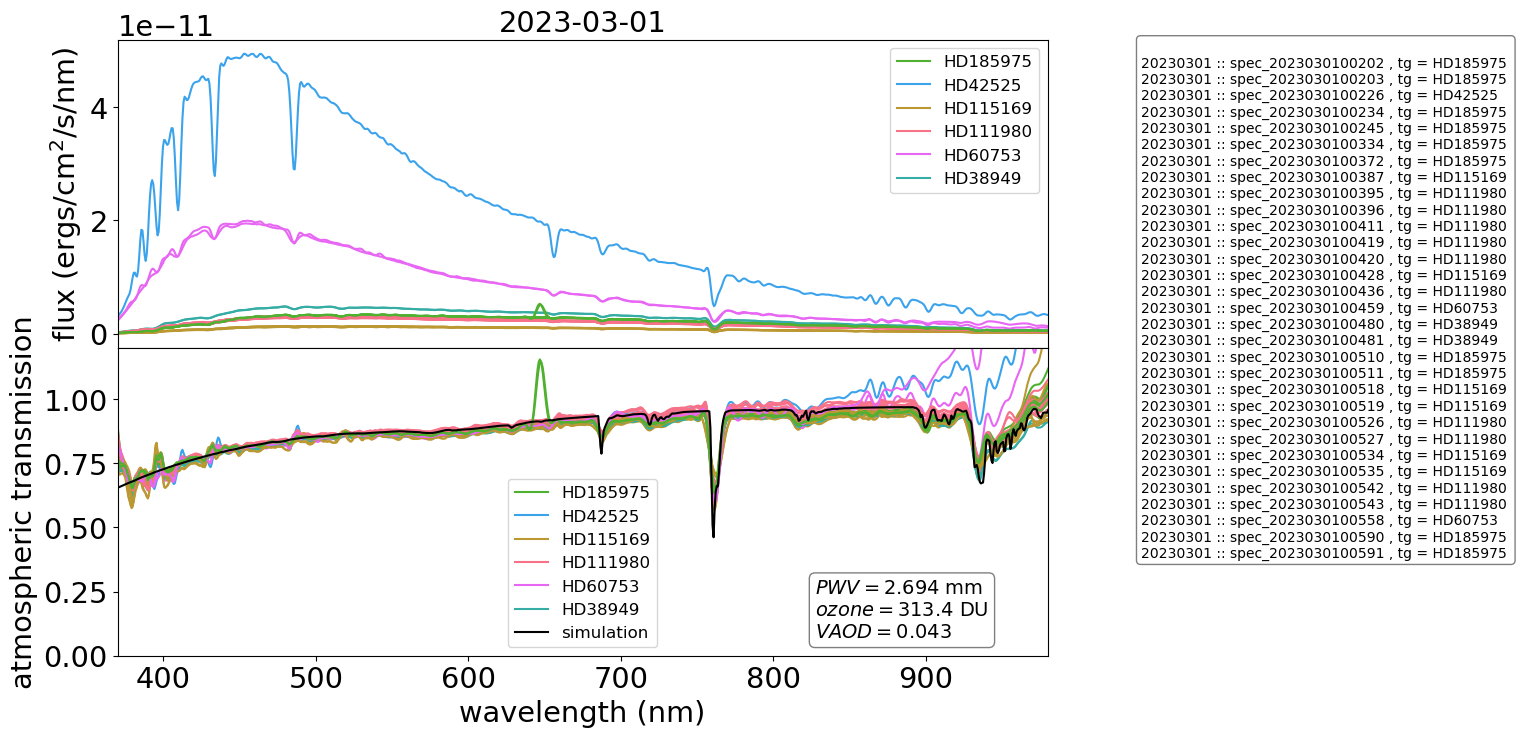

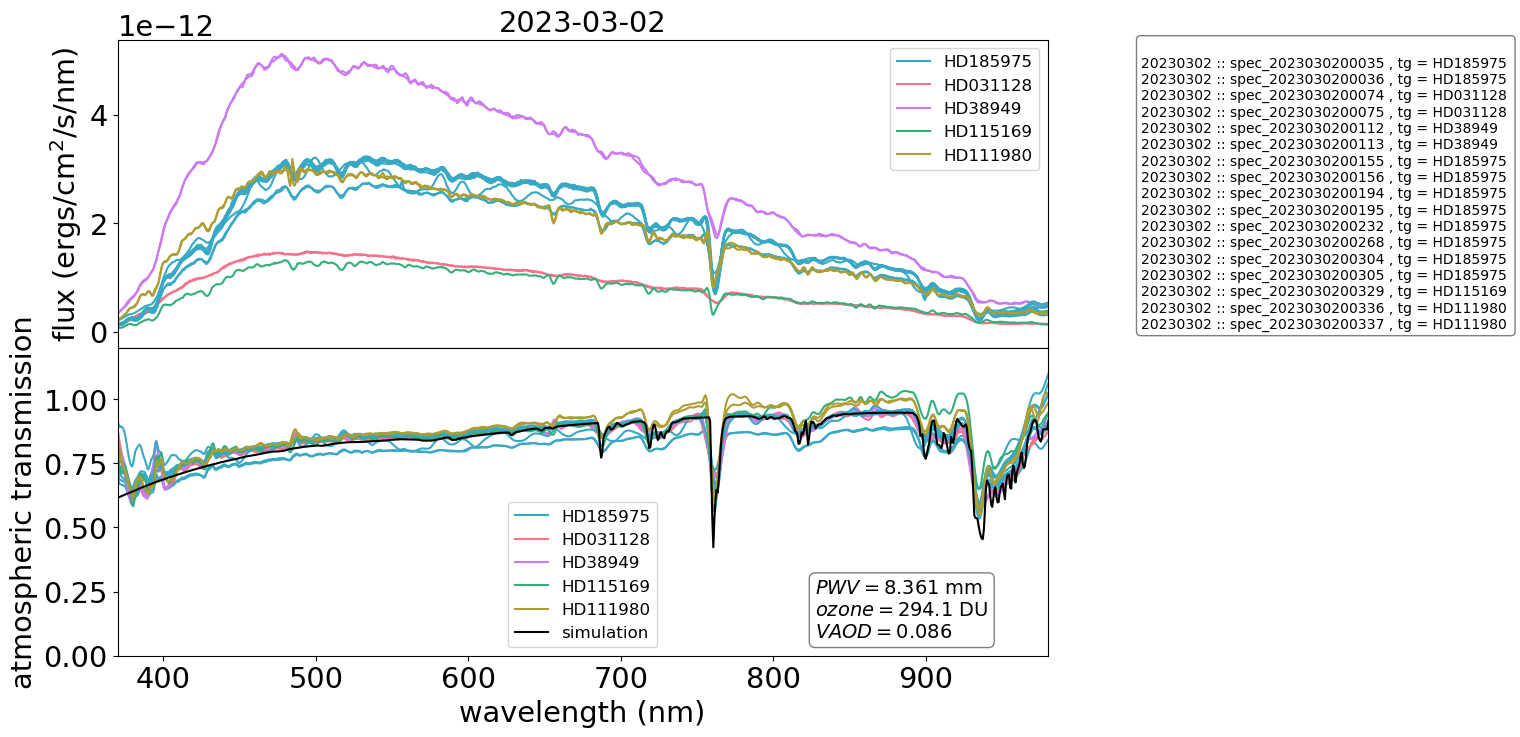

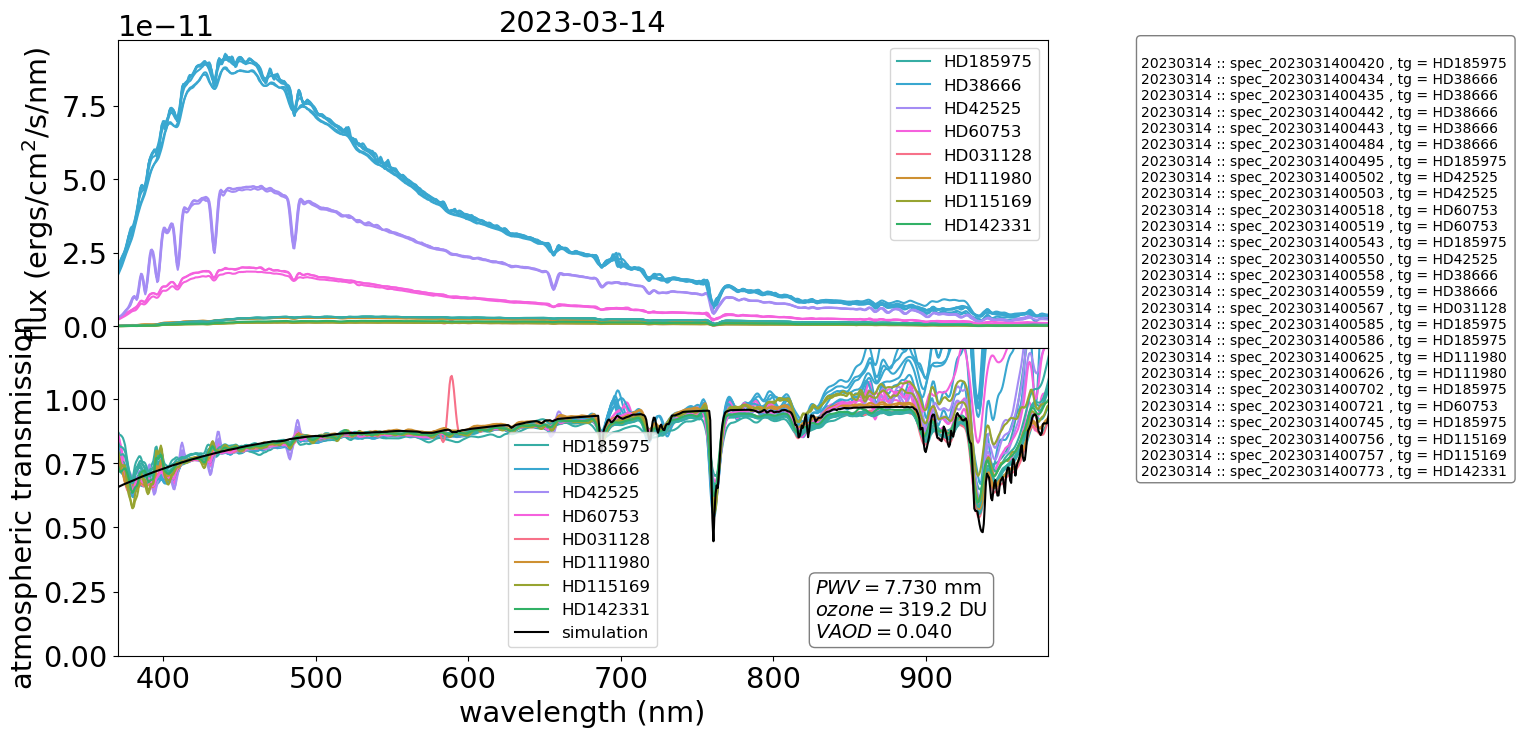

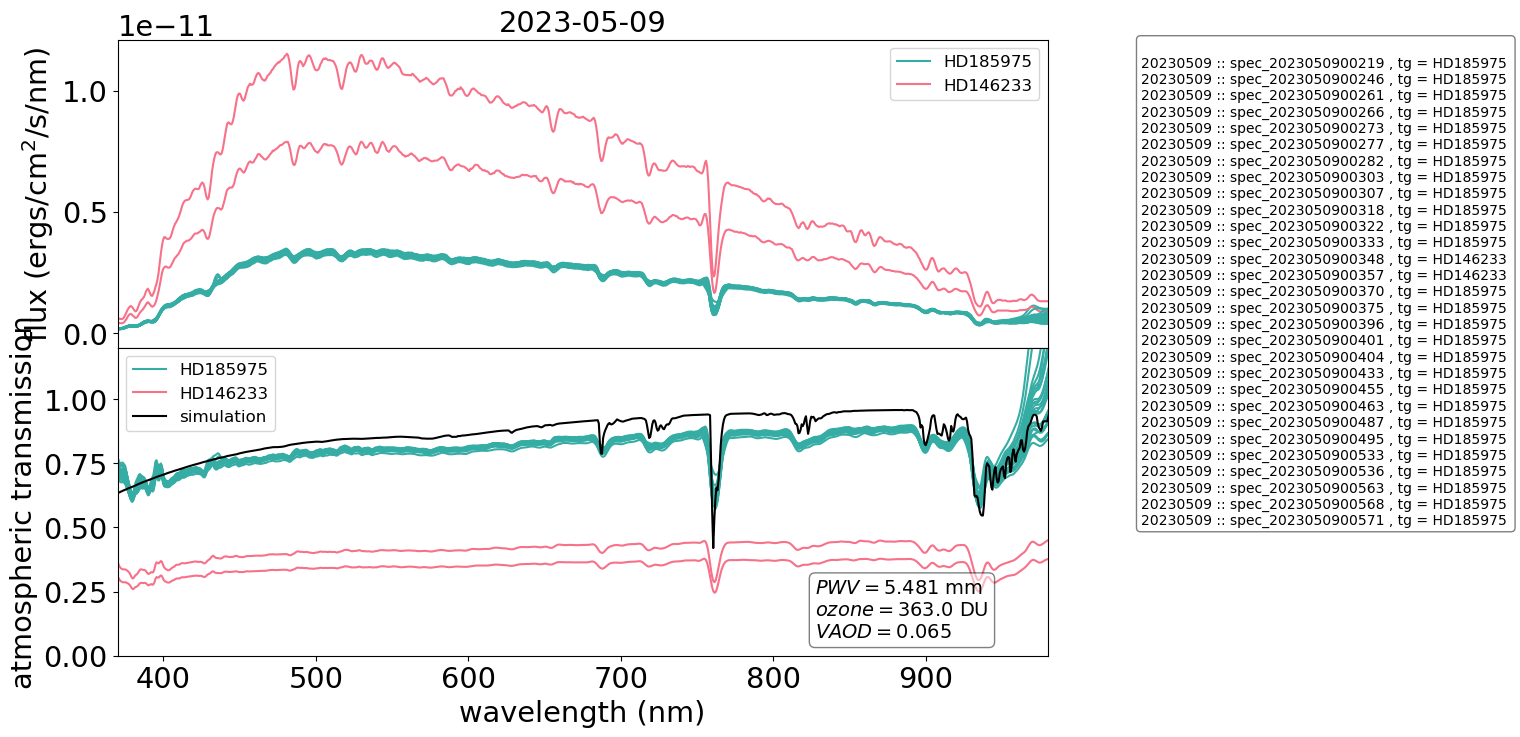

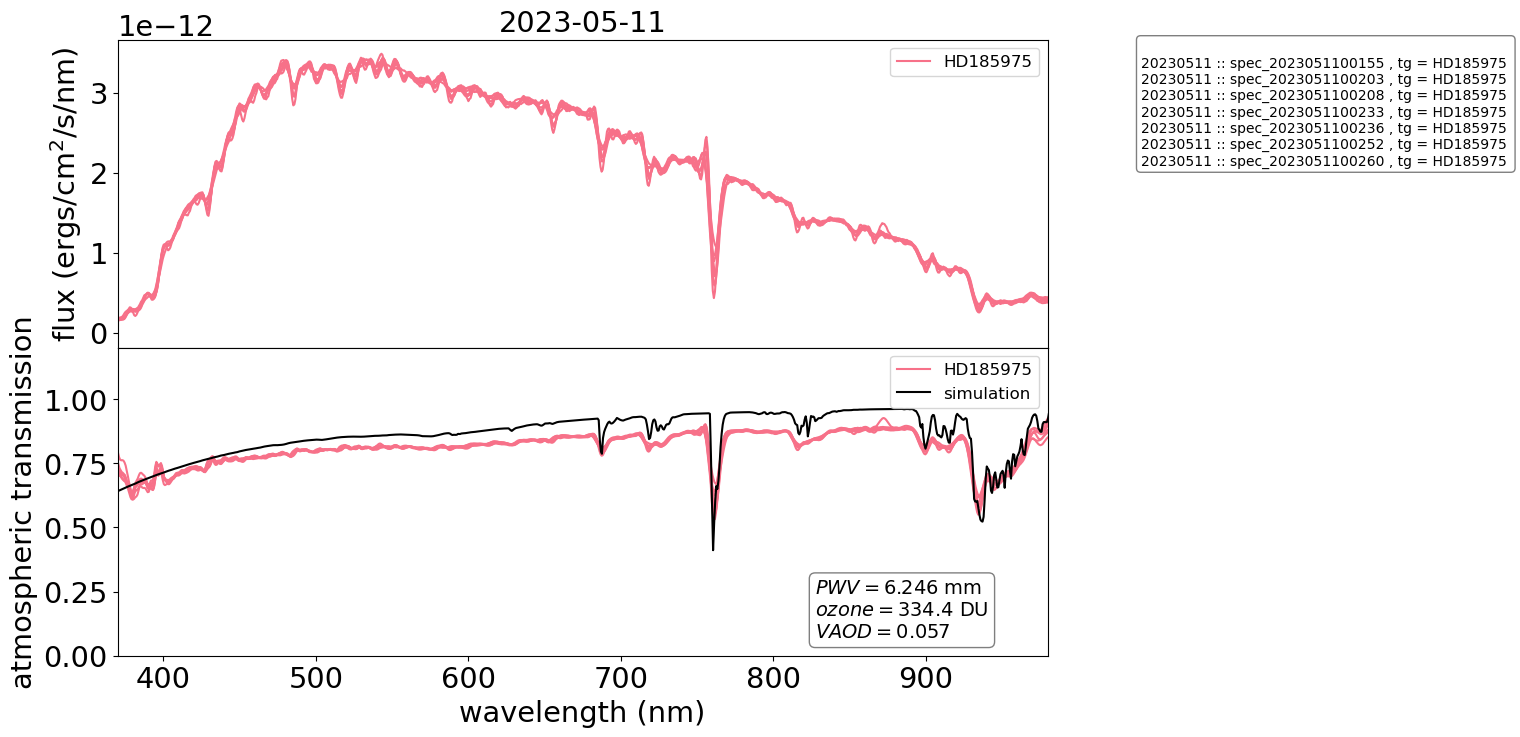

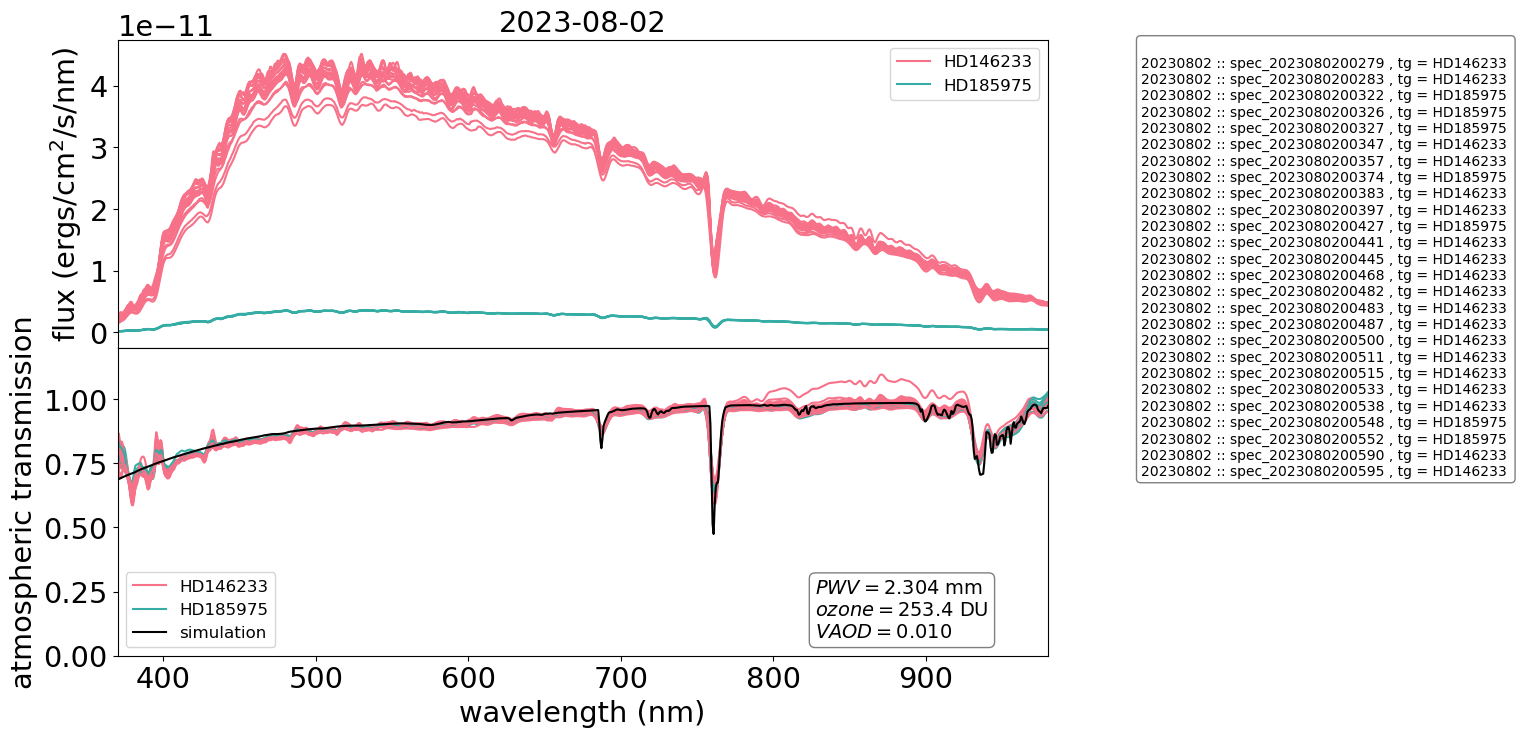

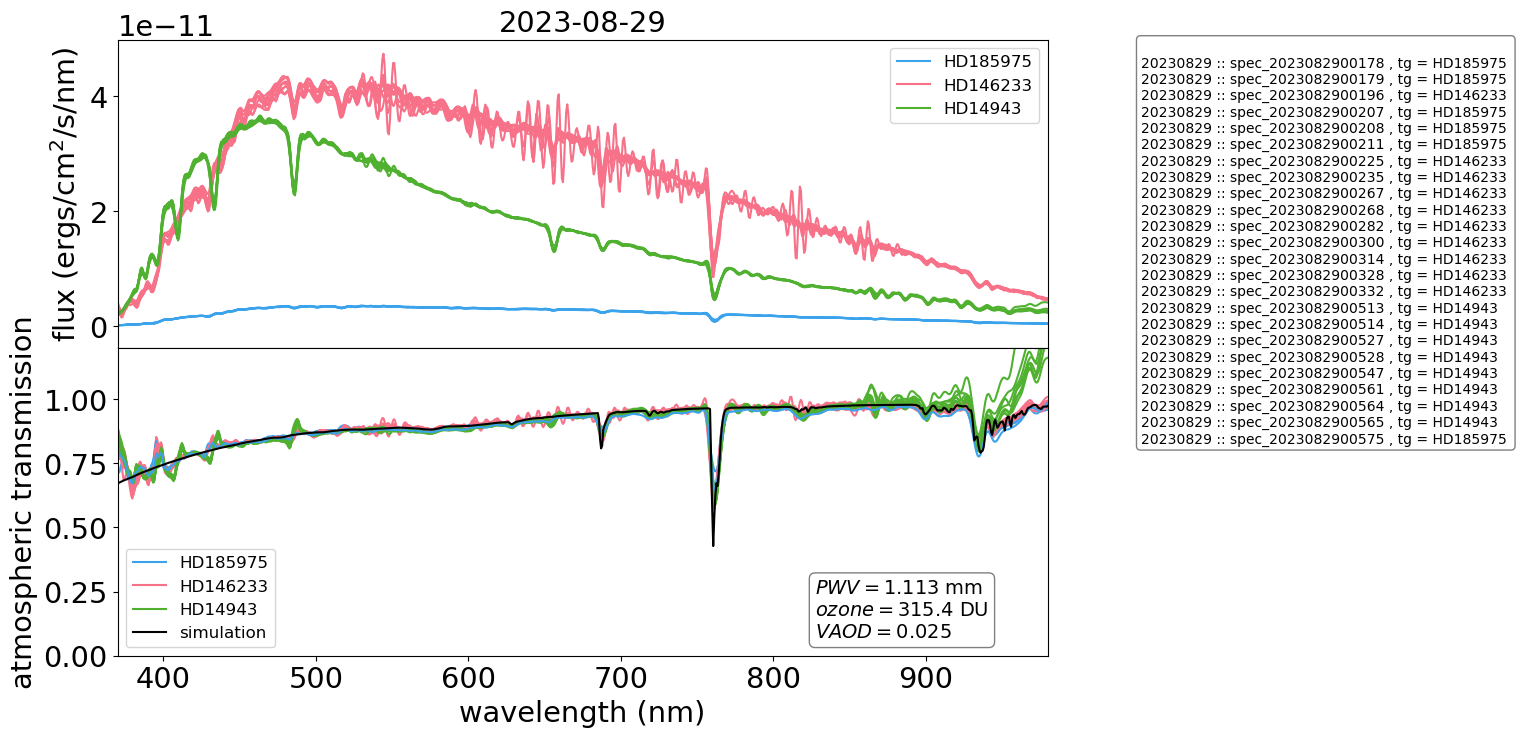

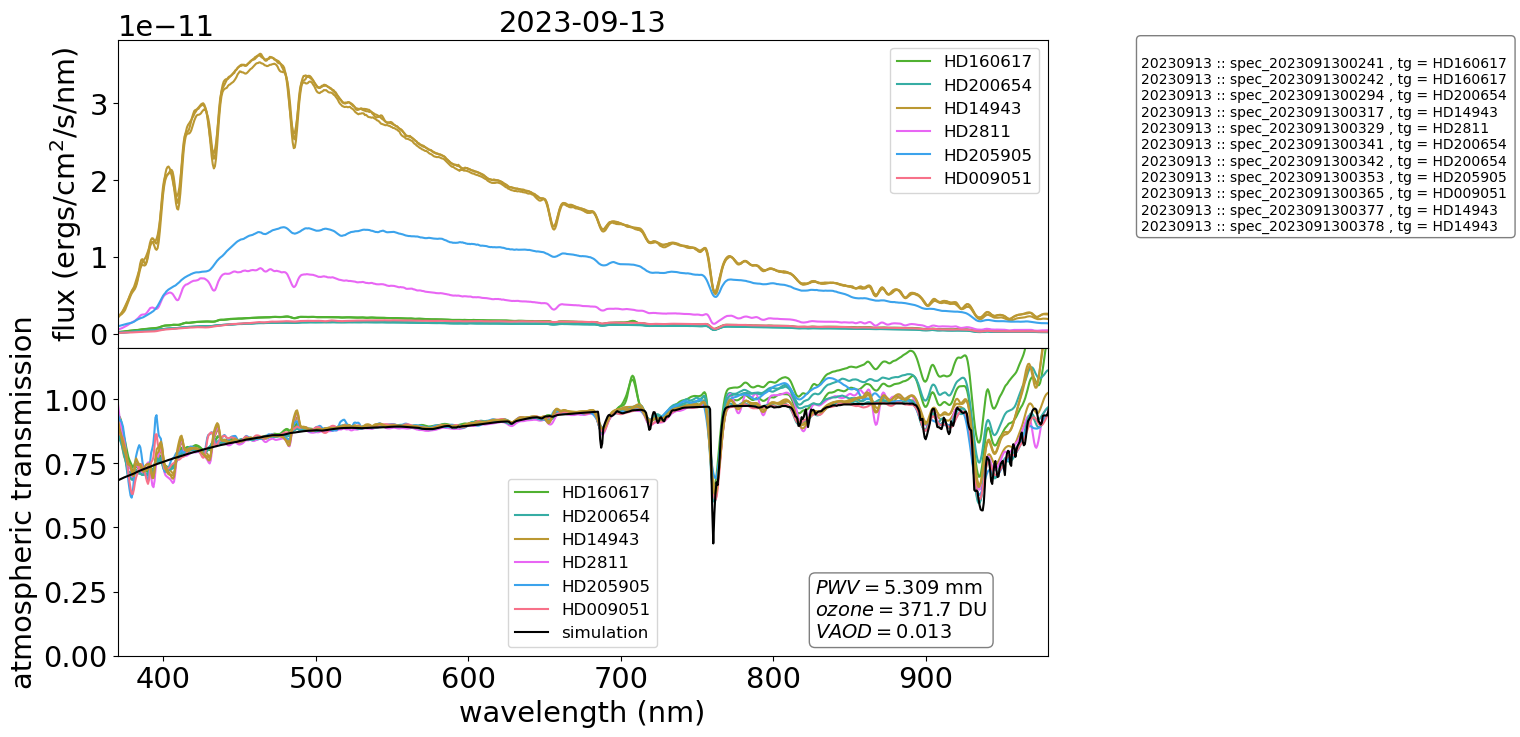

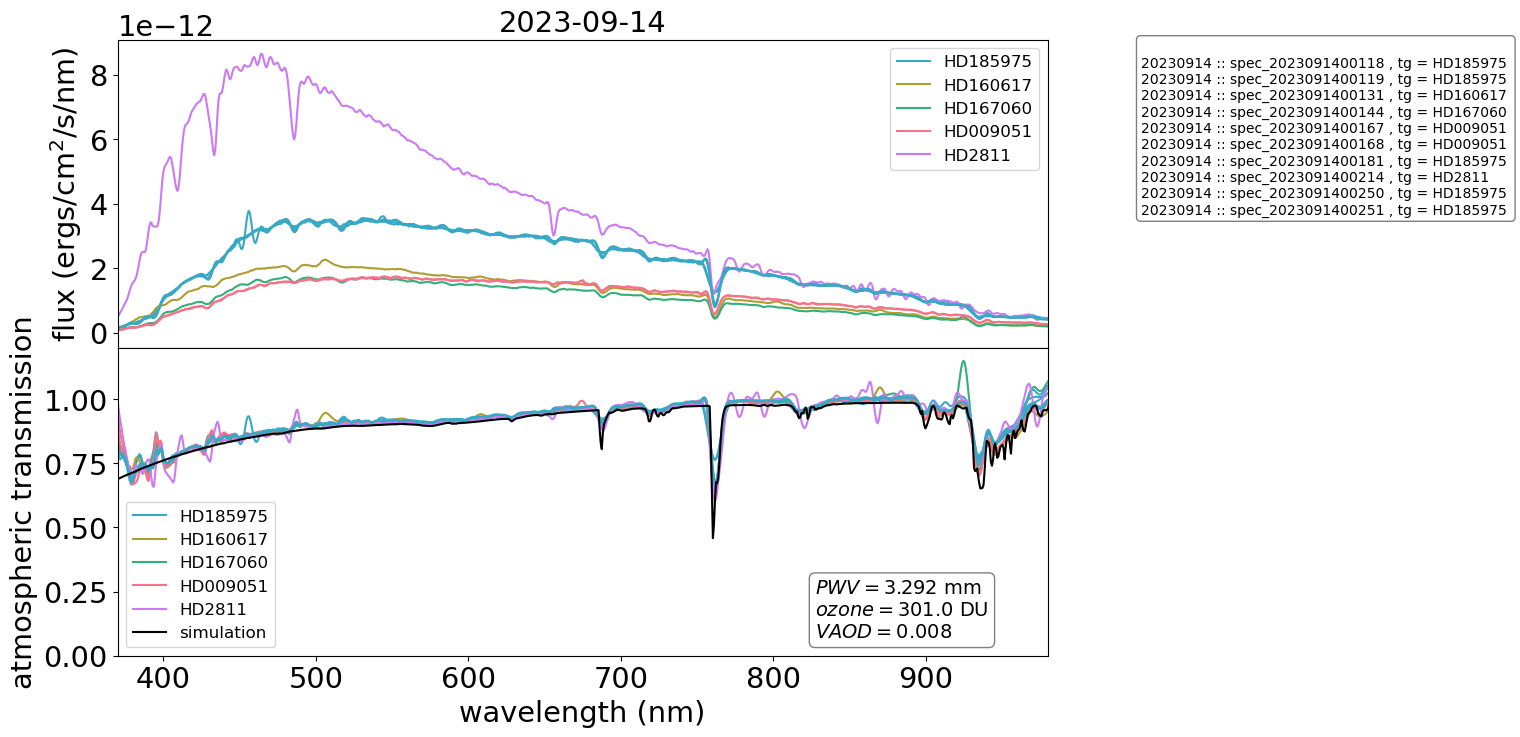

In [24]:
for nightobs in df2.nightobs.unique():
    path = get_spectra_path(nightobs)
    filename = f"spectra_transmission_ratio_{nightobs}.h5"
    fullfilename = os.path.join(path,filename)
    try:
        hf = h5py.File(fullfilename, 'r')
        PlotTransmission(hf,nightobs)
        tokeep = RetrieveAtmParameters(hf,nightobs)
        AtmParamPerNightObsDict[nightobs] = {"median":tokeep[0],"individual":tokeep[1]}
        hf.close()
    except Exception as inst:
        print(type(inst))    # the exception type
        print(inst.args)     # arguments stored in .args
        print(inst)          # __str__ allows args to be printed directly,

## Quality night in df3

In [52]:




for nightobs in df3.nightobs.unique():
    path = get_spectra_path(nightobs)
    filename = f"spectra_transmission_ratio_{nightobs}.h5"
    fullfilename = os.path.join(path,filename)
    try:
        hf = h5py.File(fullfilename, 'r')
        PlotTransmission(hf,nightobs)
        tokeep = RetrieveAtmParameters(hf,nightobs)
        AtmParamPerNightObsDict[nightobs] = {"median":tokeep[0],"individual":tokeep[1]}
        hf.close()
    except Exception as inst:
        print(type(inst))    # the exception type
        print(inst.args)     # arguments stored in .args
        print(inst)          # __str__ allows args to be printed directly,

                         # but may be overridden in exception subclasses



NameError: name 'OrderedDict' is not defined

## Save selected night atmospheric parameters

In [ ]:
with open(file_atmparamselectednights, 'wb') as fp:
    pickle.dump(AtmParamPerNightObsDict, fp)
    print(f'dictionary saved successfully to file {file_atmparamselectednights}')

## Apply quality cuts

In [26]:
cut = df["FILTER"] == "empty"
df = df[cut]

In [27]:
# convert pandas to numpy rec array
rec = df.to_records()

In [28]:
filtered = (rec["CHI2_FIT"] < 100) & (rec["PSF_REG"] > 1e-2) & (rec["D2CCD"] > 186)  & (rec["D2CCD"] < 188)  # & (np.abs(rec["PIXSHIFT"]) < 0.5) 
print(np.sum(filtered))
filtered = filtered & (rec["PWV [mm]_err_x"] > 0) & (rec["PWV [mm]_err_x"] < 5) & (rec["A1_err_y"] > 0) & (rec["A1_err_y"] < 5) & (rec["PWV [mm]_err_y"] > 0) & (rec["PWV [mm]_err_y"] < 5)
print(np.sum(filtered))
filtered = filtered & (rec["reso [pix]"] < 3)
print(np.sum(filtered))
filtered = filtered & (rec["ozone [db]_err_y"] > 0) & (rec["ozone [db]_err_y"] < 100)
print(np.sum(filtered))
filtered = filtered & (rec["A1_x"] > 0.1) & (rec["A1_x"] < 1.5)
print(np.sum(filtered))
filtered = filtered & (np.abs(rec["gamma_0_2"]) < 30) & (np.abs(rec["alpha_0_2"]) < 10)
print(np.sum(filtered))

1086
1048
1010
899
896
693


In [29]:
stars = np.unique(rec["TARGET"])
stars

array(['Feige110', 'HD 38666', 'HD 38949', 'HD 42525', 'HD009051',
       'HD031128', 'HD074000', 'HD111980', 'HD115169', 'HD142331',
       'HD146233', 'HD14943', 'HD160617', 'HD167060', 'HD185975',
       'HD200654', 'HD205905', 'HD2811', 'HD37962', 'HD38666', 'HD38949',
       'HD42525', 'HD60753'], dtype=object)

In [30]:
filters = np.unique(rec["FILTER"])
filters

array(['empty'], dtype=object)

## Plot

In [31]:
ATMMINMAX = {}
ATMMINMAX["A1_y"] = [0.1,1.9]
ATMMINMAX["chi2_y"] = [0.,500.]
ATMMINMAX["ozone [db]_y"] = [0.,600.]
ATMMINMAX["PWV [mm]_y"] = [0.,12.]
ATMMINMAX["VAOD_y"] = [0.,0.5]
ATMMINMAX["A2_y"] = [0.7,1.3]

ATMMINMAX["A1_x"] = [0.5,1.5]
ATMMINMAX["chi2_x"] = [0.,500.]
ATMMINMAX["ozone [db]_x"] = [0.,600.]
ATMMINMAX["PWV [mm]_x"] = [0.,12.]
ATMMINMAX["VAOD_x"] = [0.,0.5]
ATMMINMAX["A2_x"] = [0.7,1.3]

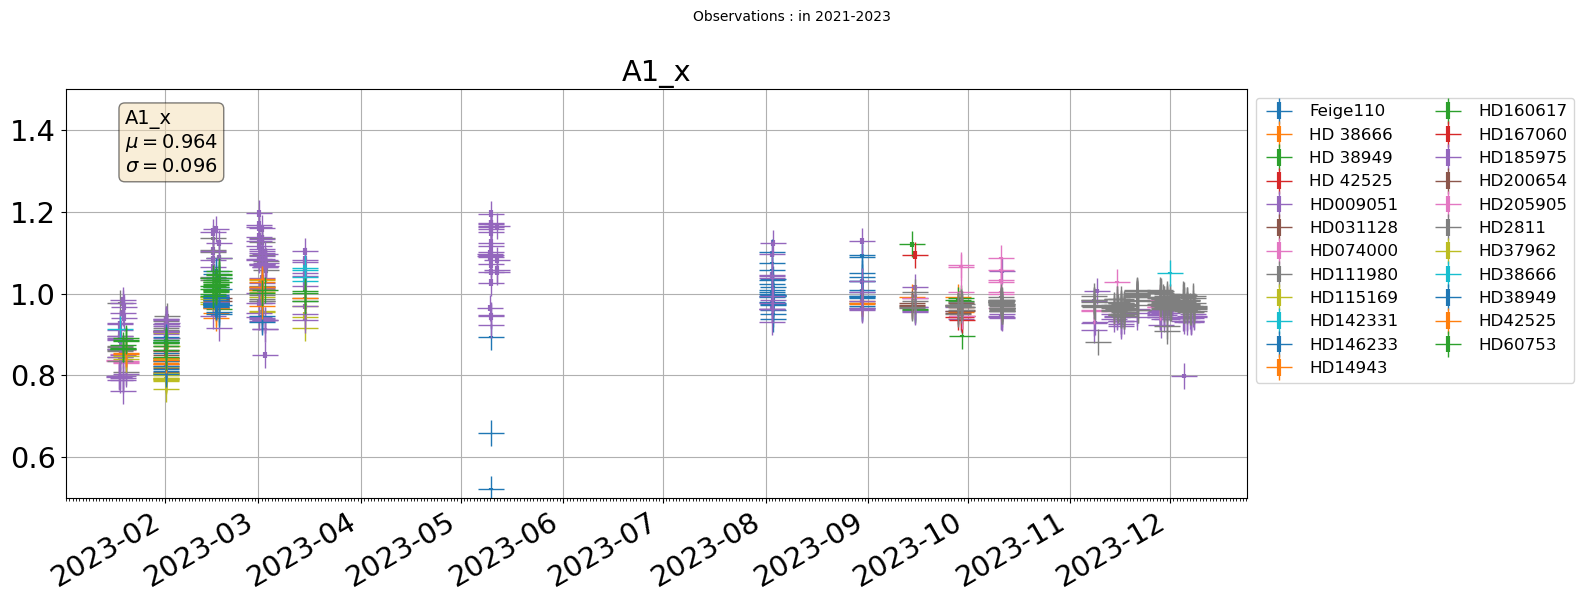

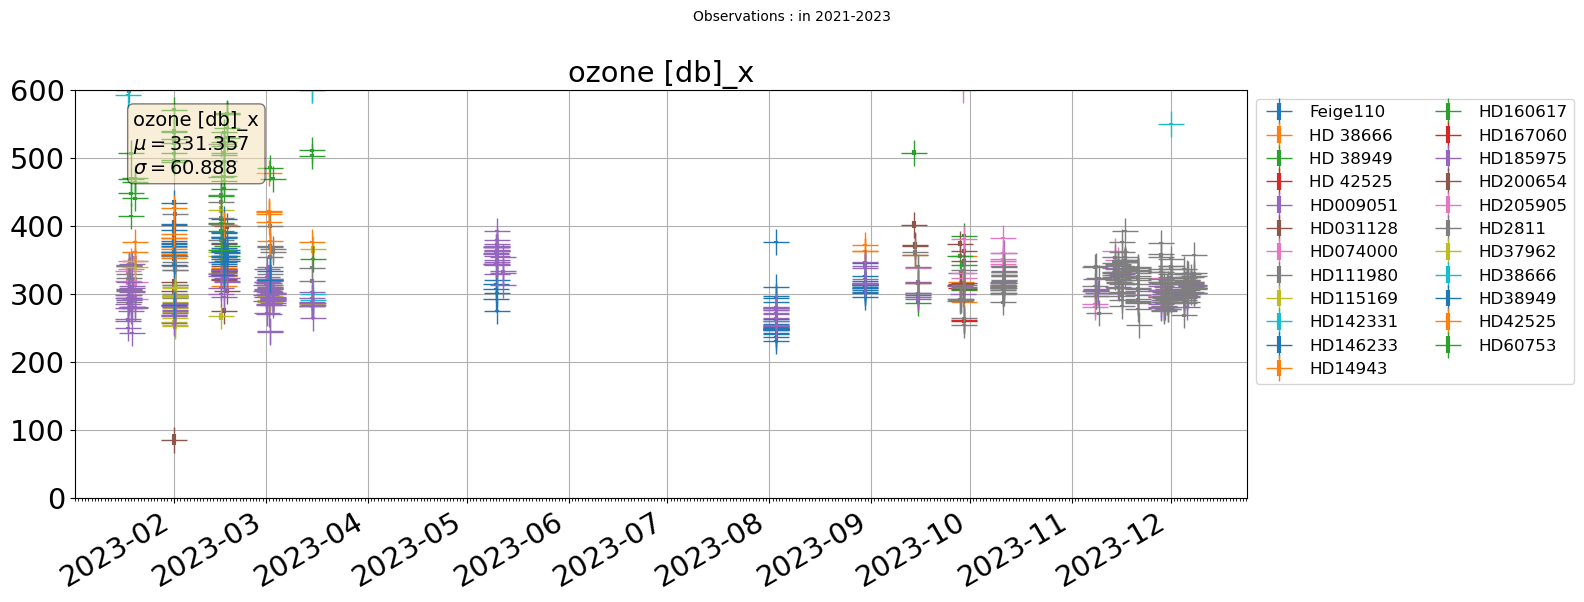

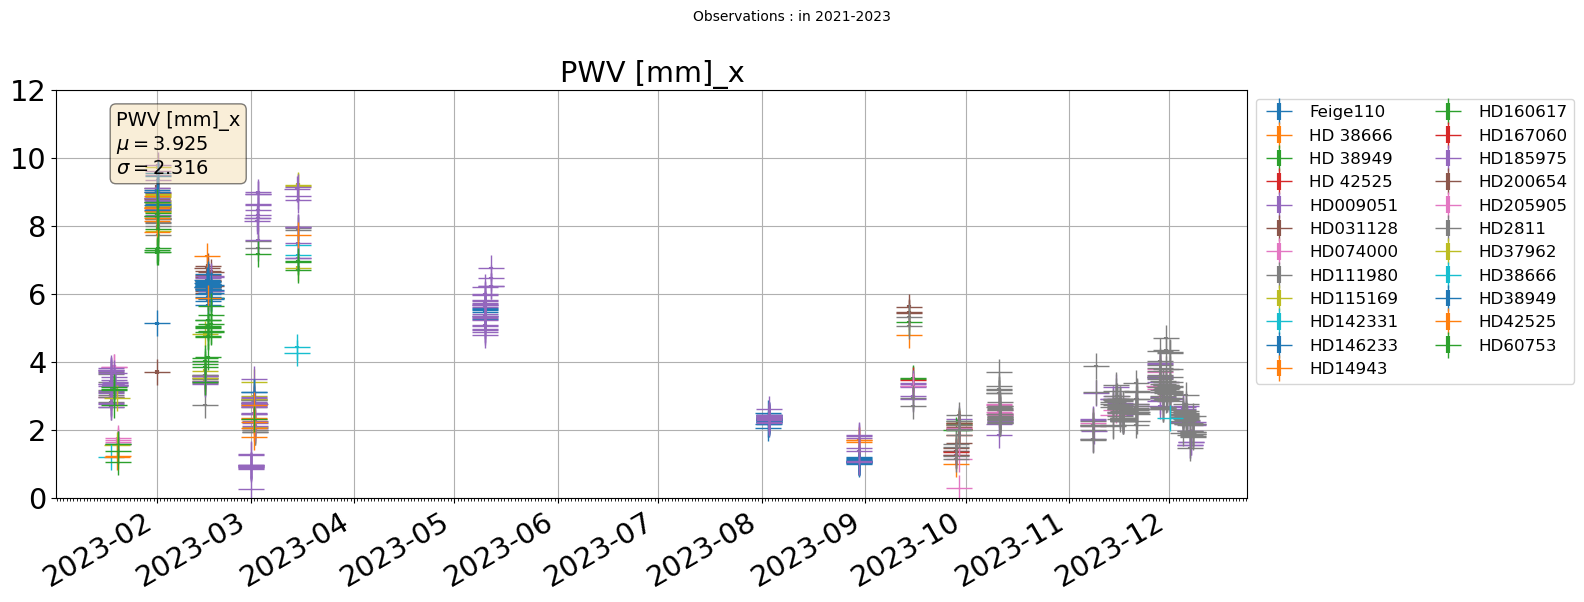

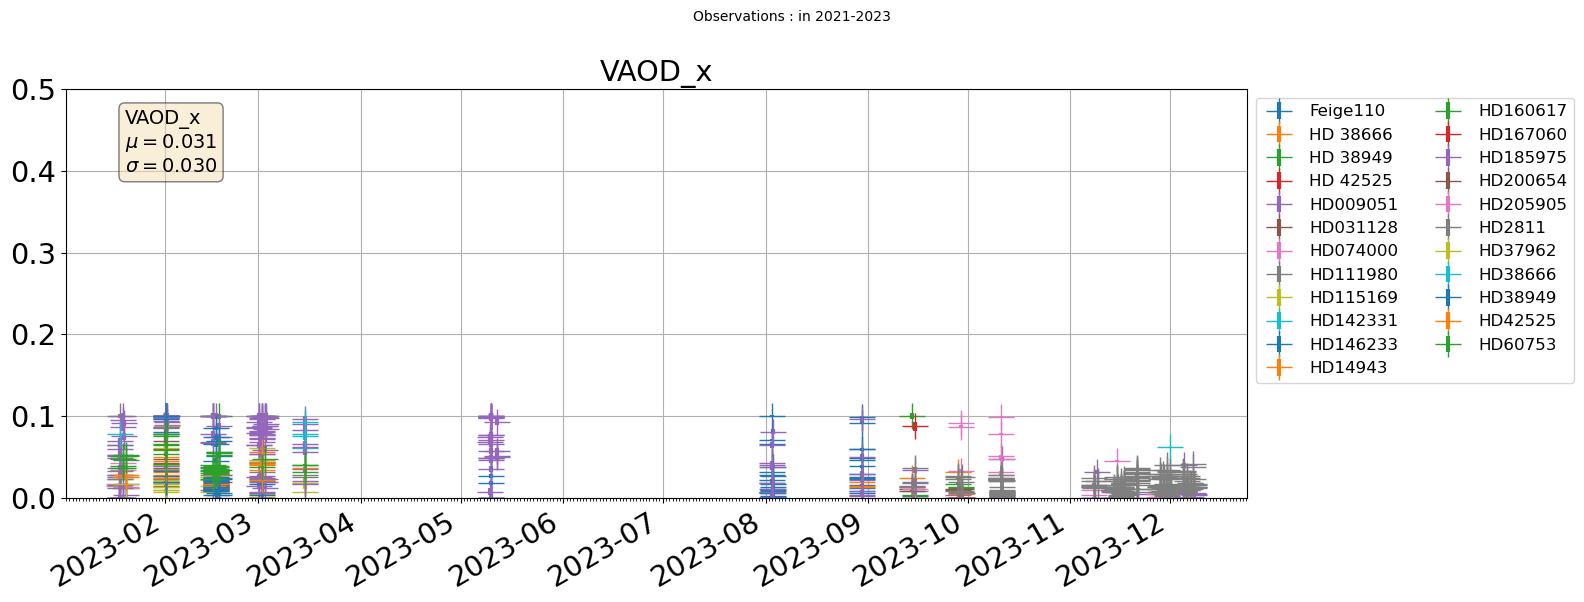

In [32]:
# Format for date
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 


for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))

    fig = plt.figure(figsize=(16,6))
    for star in stars:
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=19,lw=3 ,label=star)
        else:
            plt.plot(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], linestyle="none", marker="+",ms=10,lw=3)
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()

    ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
    ax.xaxis.set_minor_locator(day_locator)
    ax.xaxis.set_major_formatter(year_month_formatter)
    #fig.autofmt_xdate() # rotation
    
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


    plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left",ncols=2)
    plt.gcf().autofmt_xdate()
    suptitle = f"Observations : in 2021-2023"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()

## Merra2

    MERRA2_2021_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv
    MERRA2_2021_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv
    MERRA2_2022_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv
    MERRA2_2022_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv
    MERRA2_2023_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv
    MERRA2_2023_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv

In [33]:
top_merra2 = "../../../Merra2"

In [34]:
asm_merra2 = [
    #"MERRA2_2021_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv",
    #"MERRA2_2022_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv",
              "MERRA2_2023_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv"]
Nasm = len(asm_merra2)

In [35]:
aer_merra2 = [
    #"MERRA2_2021_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv",
    #"MERRA2_2022_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv",
              "MERRA2_2023_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv"]
Naer = len(aer_merra2)

In [36]:
df_asm = [pd.read_csv(os.path.join(top_merra2,file),index_col=0) for file in asm_merra2] 
df_aer = [pd.read_csv(os.path.join(top_merra2,file),index_col=0) for file in aer_merra2] 

In [37]:
df_asm[0].head()

PS       T10M        T2M        TO3       TOX  \
time                                                                        
2023-01-01 00:00:00  78620.320  284.24590  284.19403  267.12990  0.005727   
2023-01-01 01:00:00  78645.195  282.94003  282.63483  267.16120  0.005727   
2023-01-01 02:00:00  78658.790  282.69012  281.91070  266.89362  0.005721   
2023-01-01 03:00:00  78664.510  282.95117  281.80444  266.16187  0.005706   
2023-01-01 04:00:00  78652.450  283.03754  281.62714  265.97803  0.005702   

                     TQI           TQL       TQV         TS      U10M  \
time                                                                    
2023-01-01 00:00:00  0.0  2.642721e-05  5.599337  283.92380  1.750564   
2023-01-01 01:00:00  0.0  7.297844e-06  4.944884  282.22986  0.164982   
2023-01-01 02:00:00  0.0  1.972541e-06  4.232842  280.79850 -0.738192   
2023-01-01 03:00:00  0.0  5.257316e-07  3.744954  279.49896 -0.444341   
2023-01-01 04:00:00  0.0  9.333598e-08  3.388126  278.33760 -0.331920   

                          U2M      U50M      V10M       V2M      V50M  
time                                                                   
2023-01-01 00:00:00  1.238044  2.038036 -0.090943 -0.012991 -0.419707  
2023-01-01 01:00:00  0.114584  0.112569  0.002039  0.040294 -0.018076  
2023-01-01 02:00:00 -0.392655 -0.988660 -0.194765 -0.107497 -0.264359  
2023-01-01 03:00:00 -0.294611 -0.499962 -0.778797 -0.391749 -1.194732  
2023-01-01 04:00:00 -0.232934 -0.348620 -1.210167 -0.640487 -1.799269

In [38]:
df_aer[0].head()

TOTANGSTR  TOTEXTTAU  TOTSCATAU
time                                                
2023-01-01 00:30:00   1.344682   0.048491   0.045733
2023-01-01 01:30:00   1.363253   0.044516   0.041716
2023-01-01 02:30:00   1.378122   0.040857   0.038042
2023-01-01 03:30:00   1.392257   0.038250   0.035439
2023-01-01 04:30:00   1.408844   0.036092   0.033277

In [39]:
df_asm[0].index

Index(['2023-01-01 00:00:00', '2023-01-01 01:00:00', '2023-01-01 02:00:00',
       '2023-01-01 03:00:00', '2023-01-01 04:00:00', '2023-01-01 05:00:00',
       '2023-01-01 06:00:00', '2023-01-01 07:00:00', '2023-01-01 08:00:00',
       '2023-01-01 09:00:00',
       ...
       '2023-12-31 14:00:00', '2023-12-31 15:00:00', '2023-12-31 16:00:00',
       '2023-12-31 17:00:00', '2023-12-31 18:00:00', '2023-12-31 19:00:00',
       '2023-12-31 20:00:00', '2023-12-31 21:00:00', '2023-12-31 22:00:00',
       '2023-12-31 23:00:00'],
      dtype='object', name='time', length=8760)

Text(0.5, 1.0, 'Merra2 Ozone')

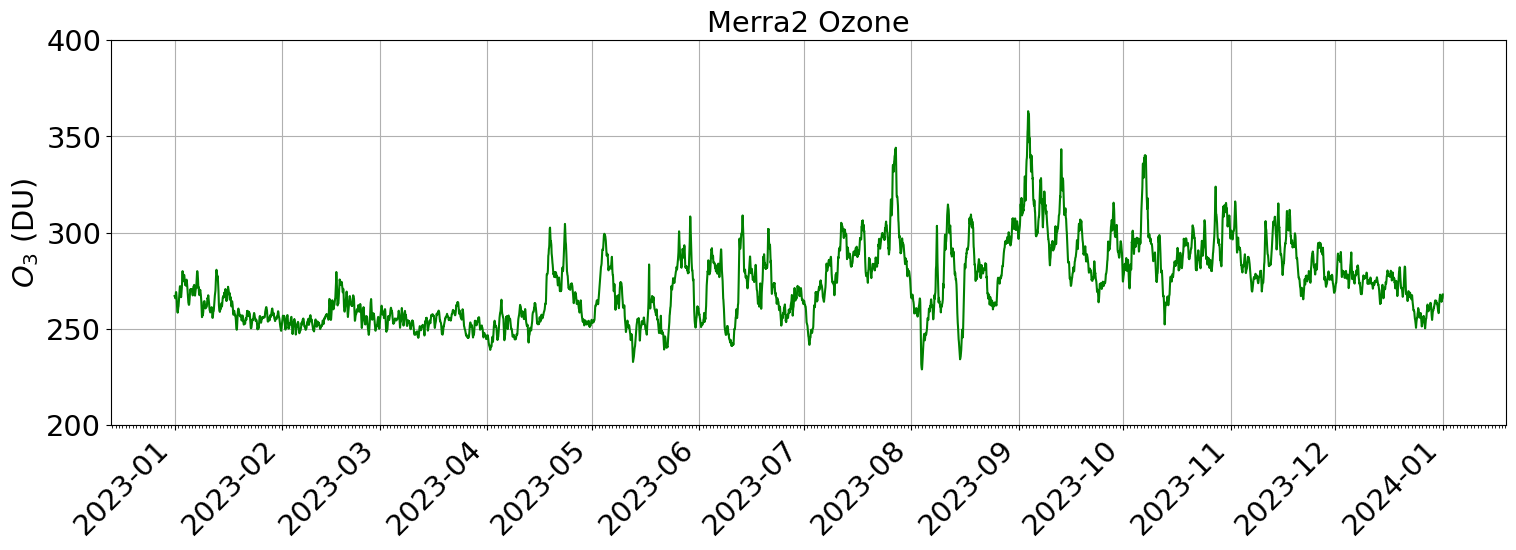

In [40]:
fig, ax = plt.subplots(1,1,figsize=(18, 5))

month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 


ax.plot(pd.to_datetime(df_asm[0].index),df_asm[0].TO3,'g-')
#ax.plot(pd.to_datetime(df_asm[1].index),df_asm[1].TO3,'r-')
#ax.plot(pd.to_datetime(df_asm[2].index),df_asm[2].TO3,'b-')

ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.grid()
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right');
ax.set_ylim(200.,400.)
ax.set_ylabel("$O_3$ (DU)")
ax.set_title("Merra2 Ozone")



In [41]:
df["dateobs"].values

array(['2023-01-17T00:00:00.000000000', '2023-01-17T00:00:00.000000000',
       '2023-01-17T00:00:00.000000000', ...,
       '2023-12-07T00:00:00.000000000', '2023-12-07T00:00:00.000000000',
       '2023-12-07T00:00:00.000000000'], dtype='datetime64[ns]')

Text(0.5, 1.0, 'Merra2 Precipitable Water Vapor')

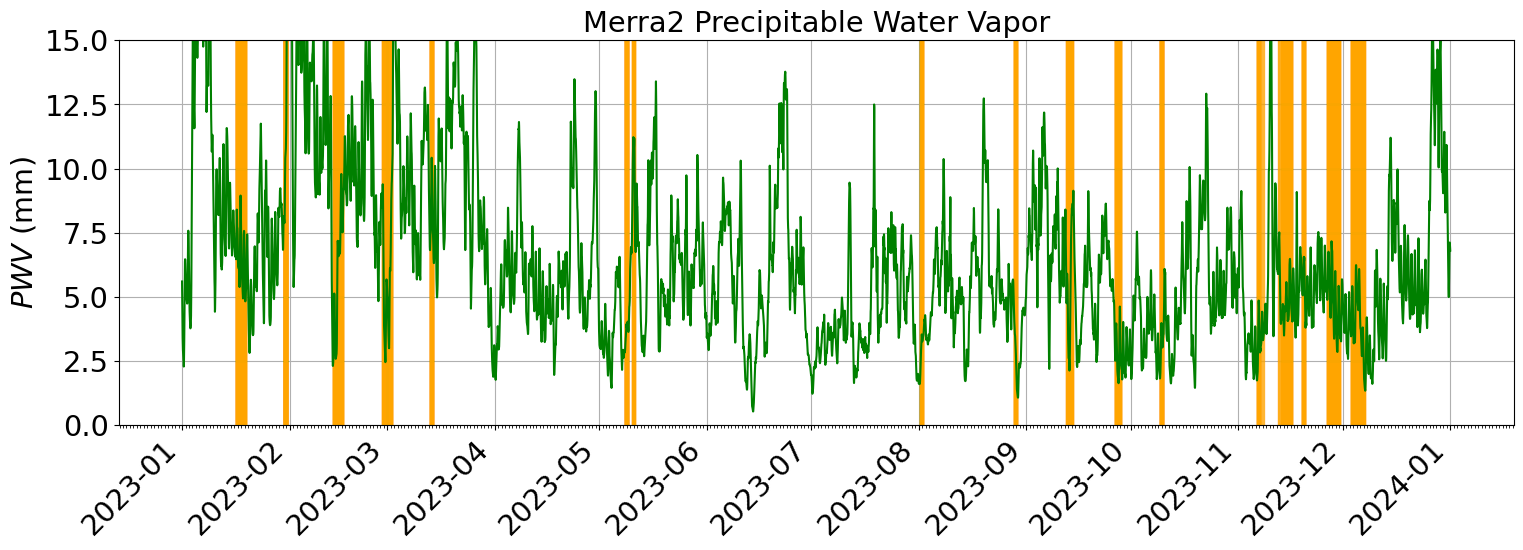

In [42]:
fig, ax = plt.subplots(1,1,figsize=(18, 5))

month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 

for dateobs in df["dateobs"]:
    ax.axvline(dateobs,color="orange",lw=3,alpha=0.2)

ax.plot(pd.to_datetime(df_asm[0].index),df_asm[0].TQV,'g-')
#ax.plot(pd.to_datetime(df_asm[1].index),df_asm[1].TQV,'r-')
#ax.plot(pd.to_datetime(df_asm[2].index),df_asm[2].TQV,'b-')

ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.grid()
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right');

ax.set_ylim(0.,15.)
ax.set_ylabel("$PWV$ (mm)")
ax.set_title("Merra2 Precipitable Water Vapor")


Text(0.5, 1.0, 'Merra2 Aerosol Extinction')

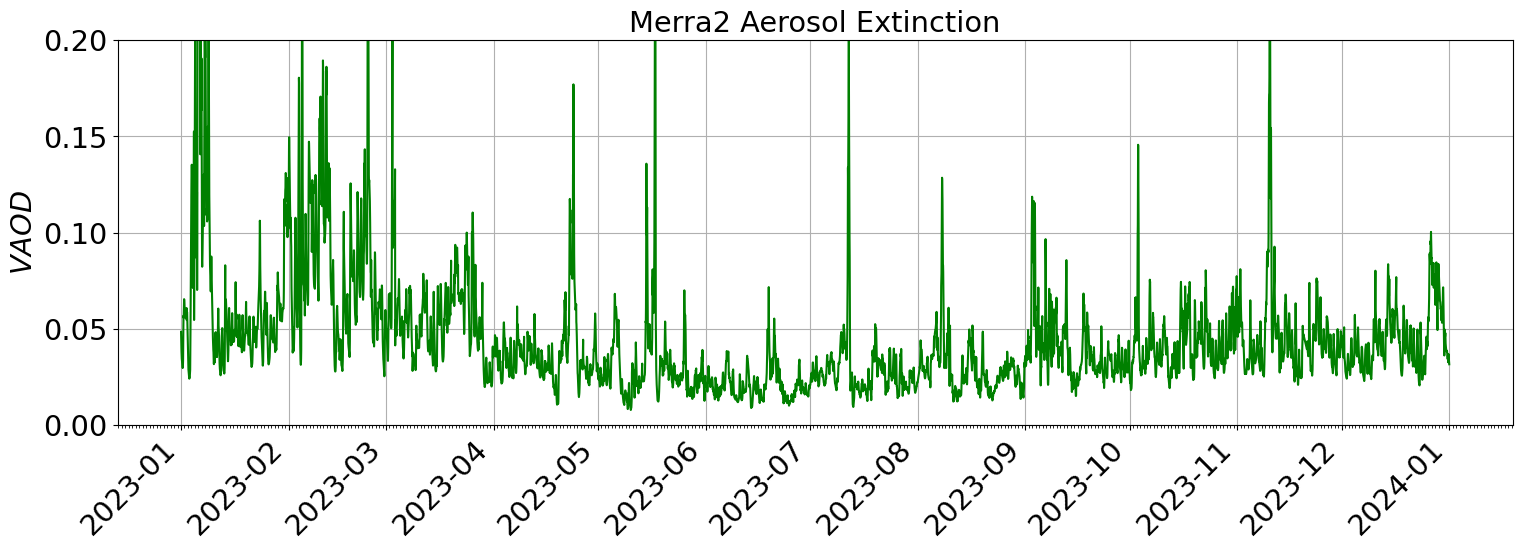

In [43]:
fig, ax = plt.subplots(1,1,figsize=(18, 5))

month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 

ax.plot(pd.to_datetime(df_aer[0].index),df_aer[0].TOTEXTTAU,'g-')
#ax.plot(pd.to_datetime(df_aer[1].index),df_aer[1].TOTEXTTAU,'r-')
#ax.plot(pd.to_datetime(df_aer[2].index),df_aer[2].TOTEXTTAU,'b-')

ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.grid()
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right');

ax.set_ylim(0.,.2)
ax.set_ylabel("$VAOD$")
ax.set_title("Merra2 Aerosol Extinction")

Text(0.5, 1.0, 'Merra2 Aerosol Scattering')

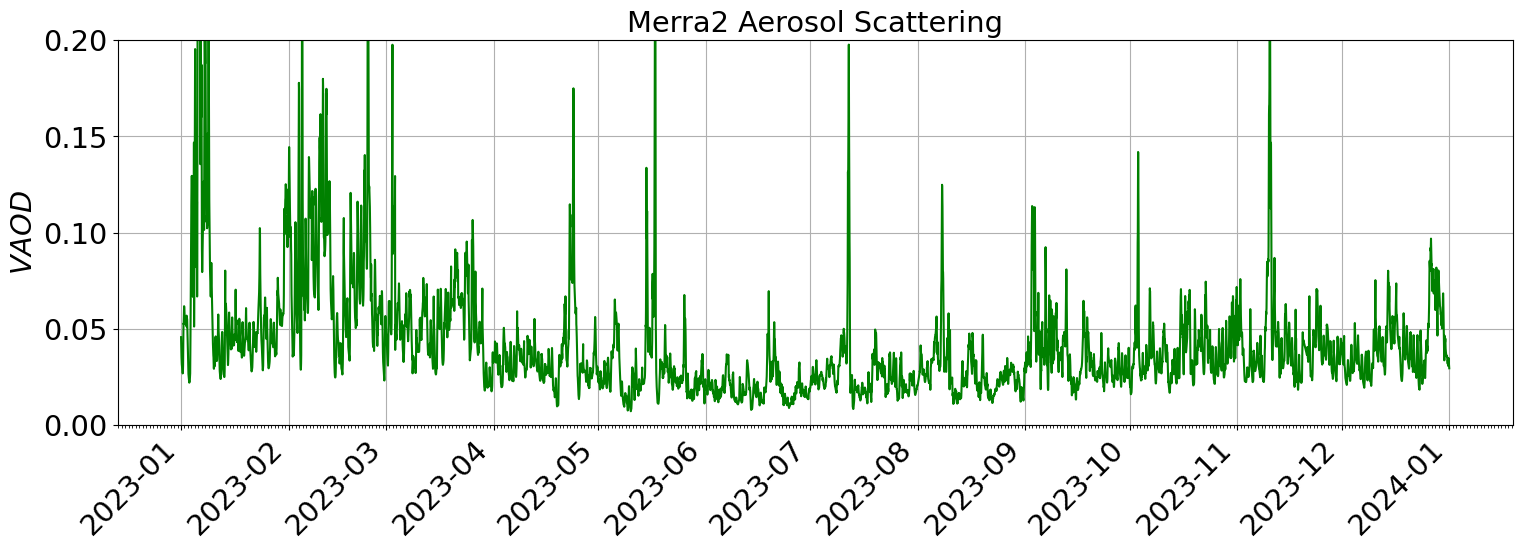

In [44]:
fig, ax = plt.subplots(1,1,figsize=(18, 5))

month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 

    
ax.plot(pd.to_datetime(df_aer[0].index),df_aer[0].TOTSCATAU,'g-')
#ax.plot(pd.to_datetime(df_aer[1].index),df_aer[1].TOTSCATAU,'r-')
#ax.plot(pd.to_datetime(df_aer[2].index),df_aer[2].TOTSCATAU,'b-')

ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.grid()
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right');

ax.set_ylim(0.,.2)
ax.set_ylabel("$VAOD$")
ax.set_title("Merra2 Aerosol Scattering")

Text(0.5, 1.0, 'Merra2 Aerosol exponent')

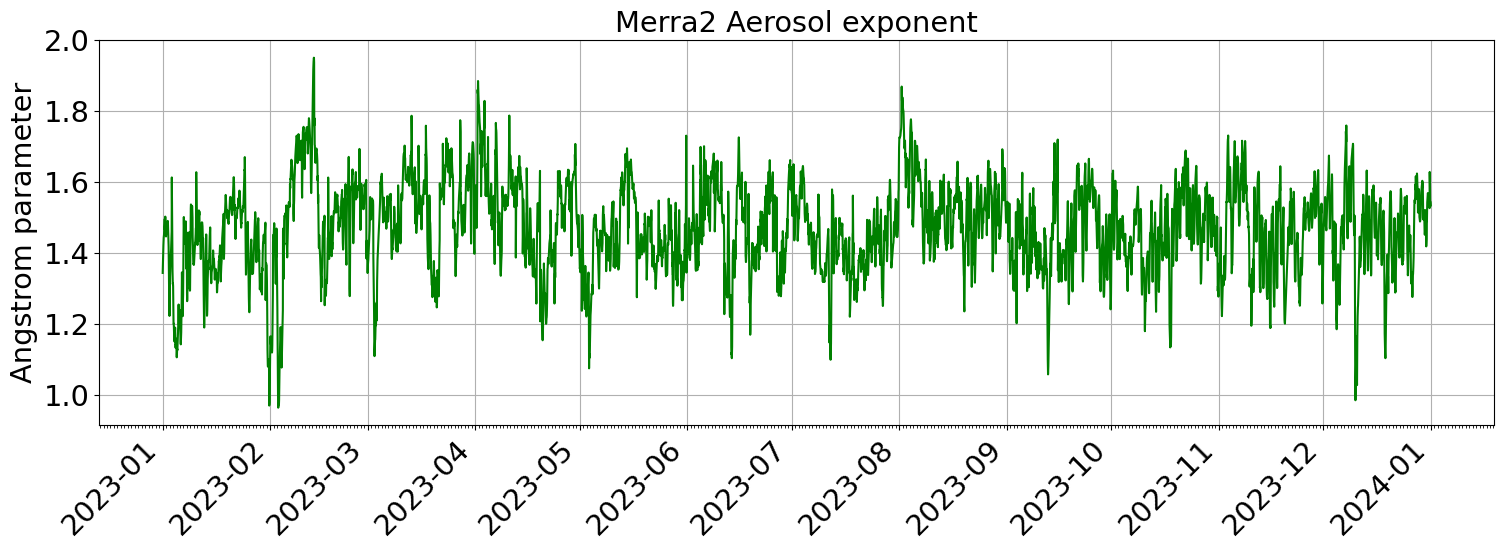

In [45]:
fig, ax = plt.subplots(1,1,figsize=(18, 5))

month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 


ax.plot(pd.to_datetime(df_aer[0].index),df_aer[0].TOTANGSTR,'g-')
#ax.plot(pd.to_datetime(df_aer[1].index),df_aer[1].TOTANGSTR,'r-')
#ax.plot(pd.to_datetime(df_aer[2].index),df_aer[2].TOTANGSTR,'b-')

ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.grid()
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right');

#ax.set_ylim(0.,2.)
ax.set_ylabel("Angstrom parameter")
ax.set_title("Merra2 Aerosol exponent")

## Ozone

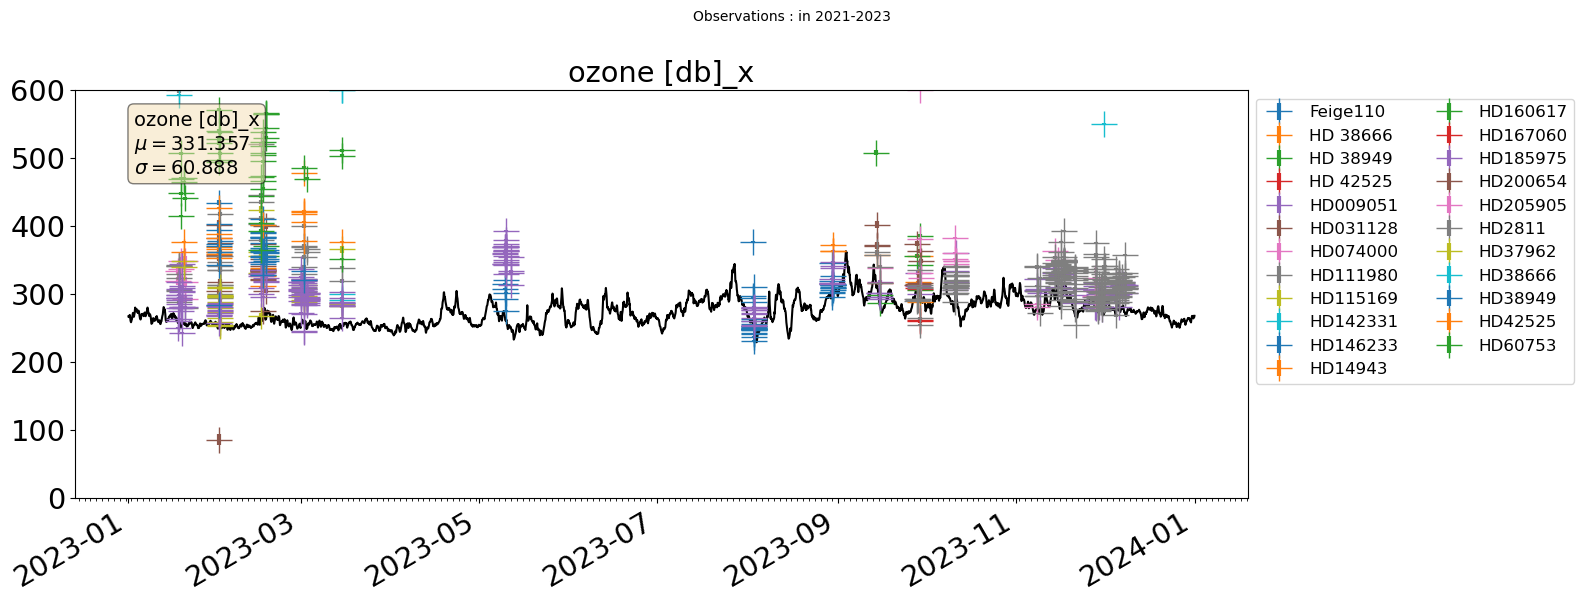

In [46]:
# Format for date
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=2)
day_locator = mdates.DayLocator(interval=2)
year_month_formatter = mdates.DateFormatter("%Y-%m") 


#for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x"]:
for col in ["ozone [db]_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))

    fig = plt.figure(figsize=(16,6))
    for star in stars:
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=19,lw=3 ,label=star)
        else:
            plt.plot(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], linestyle="none", marker="+",ms=10,lw=3)
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()

    ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
    ax.xaxis.set_minor_locator(day_locator)
    ax.xaxis.set_major_formatter(year_month_formatter)
    #fig.autofmt_xdate() # rotation
    
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


    ax.plot(pd.to_datetime(df_asm[0].index),df_asm[0].TO3,'k-')
    #ax.plot(pd.to_datetime(df_asm[1].index),df_asm[1].TO3,'k-')
    #ax.plot(pd.to_datetime(df_asm[2].index),df_asm[2].TO3,'k-')
    
    #plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left",ncols=2)
    plt.gcf().autofmt_xdate()
    suptitle = f"Observations : in 2021-2023"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()

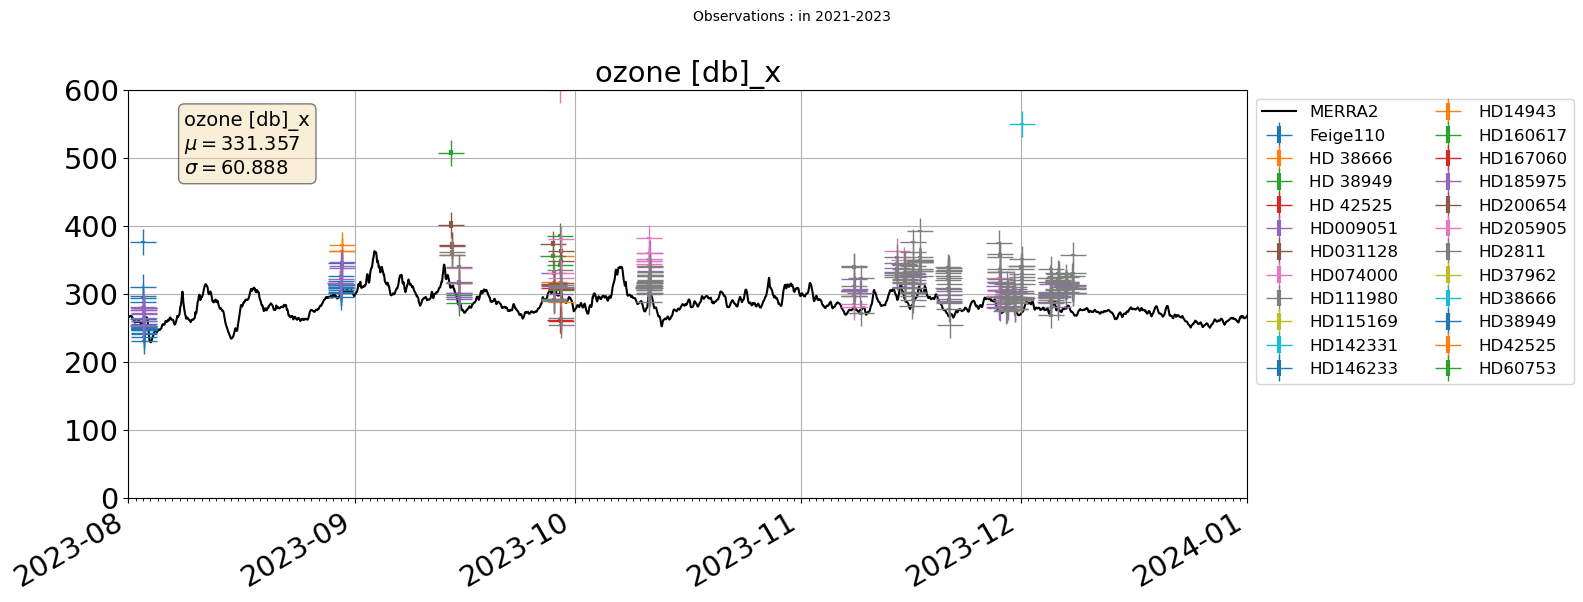

In [47]:
# Format for date
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 


#for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x"]:
for col in ["ozone [db]_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))

    fig = plt.figure(figsize=(16,6))
    for star in stars:
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=19,lw=3 ,label=star)
        else:
            plt.plot(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], linestyle="none", marker="+",ms=10,lw=3)
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()

    ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
    ax.xaxis.set_minor_locator(day_locator)
    ax.xaxis.set_major_formatter(year_month_formatter)
    #fig.autofmt_xdate() # rotation
    
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


    ax.plot(pd.to_datetime(df_asm[0].index),df_asm[0].TO3,'k-',label="MERRA2")
    #ax.plot(pd.to_datetime(df_asm[1].index),df_asm[1].TO3,'k-')
    #ax.plot(pd.to_datetime(df_asm[2].index),df_asm[2].TO3,'k-')
    ax.set_xlim(pd.to_datetime('2023-08-01 00:00:00'),pd.to_datetime('2024-01-01 00:00:00'))
    ax.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left",ncols=2)
    plt.gcf().autofmt_xdate()
    suptitle = f"Observations : in 2021-2023"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()

## PWV

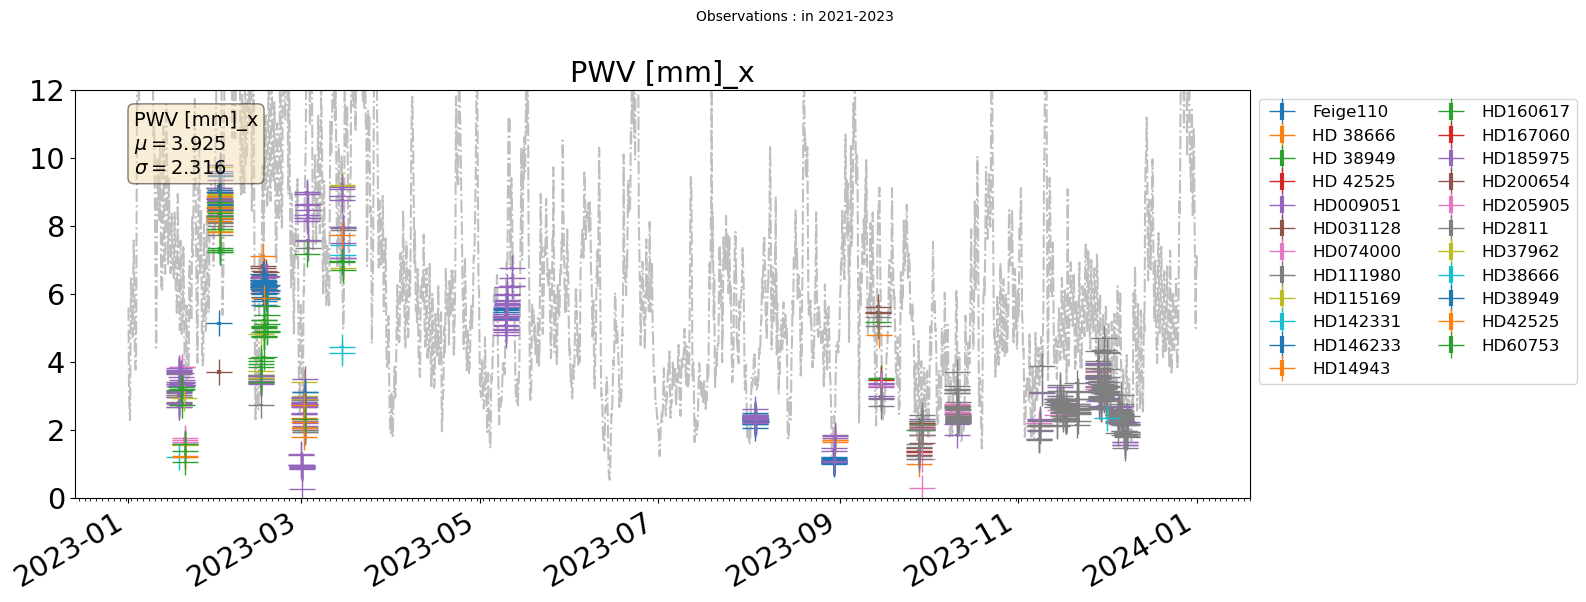

In [48]:
# Format for date
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=2)
day_locator = mdates.DayLocator(interval=2)
year_month_formatter = mdates.DateFormatter("%Y-%m") 


#for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x"]:
for col in ["PWV [mm]_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))

    fig = plt.figure(figsize=(16,6))
    for star in stars:
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=19,lw=3 ,label=star)
        else:
            plt.plot(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], linestyle="none", marker="+",ms=10,lw=3)
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()

    ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
    ax.xaxis.set_minor_locator(day_locator)
    ax.xaxis.set_major_formatter(year_month_formatter)
    #fig.autofmt_xdate() # rotation
    
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


    ax.plot(pd.to_datetime(df_asm[0].index),df_asm[0].TQV,'-.',color="grey",alpha=0.5)
    #ax.plot(pd.to_datetime(df_asm[1].index),df_asm[1].TQV,'-.',color="grey",alpha=0.5)
    #ax.plot(pd.to_datetime(df_asm[2].index),df_asm[2].TQV,'-.',color="grey",alpha=0.5)
    
    #plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left",ncols=2)
    plt.gcf().autofmt_xdate()
    suptitle = f"Observations : in 2021-2023"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()

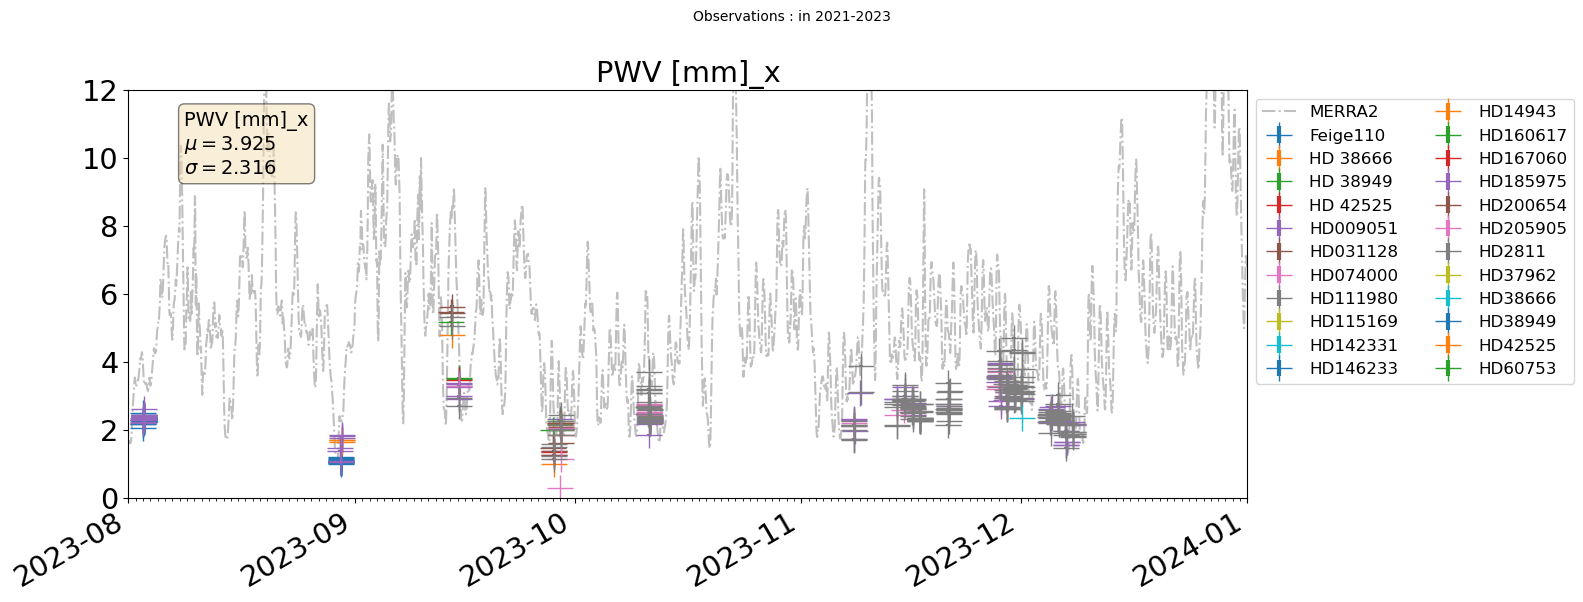

In [49]:
# Format for date
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 


#for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x"]:
for col in ["PWV [mm]_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))

    fig = plt.figure(figsize=(16,6))
    for star in stars:
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=19,lw=3 ,label=star)
        else:
            plt.plot(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], linestyle="none", marker="+",ms=10,lw=3)
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()

    ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
    ax.xaxis.set_minor_locator(day_locator)
    ax.xaxis.set_major_formatter(year_month_formatter)
    #fig.autofmt_xdate() # rotation
    
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


    ax.plot(pd.to_datetime(df_asm[0].index),df_asm[0].TQV,'-.',color="grey",alpha=0.5,label="MERRA2")
    #ax.plot(pd.to_datetime(df_asm[1].index),df_asm[1].TQV,'-.',color="grey",alpha=0.5)
    #ax.plot(pd.to_datetime(df_asm[2].index),df_asm[2].TQV,'-.',color="grey",alpha=0.5)
    ax.set_xlim(pd.to_datetime('2023-08-01 00:00:00'),pd.to_datetime('2024-01-01 00:00:00'))
    
    #plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left",ncols=2)
    plt.gcf().autofmt_xdate()
    suptitle = f"Observations : in 2021-2023"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()